# Mountaincar

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to push the car to the mountaintop on the right.

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0.6 & 0 
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The initial position is within $[-0.6, -0.4]$.

In [1]:
%matplotlib inline

import importlib



In [2]:
from __future__ import print_function
import sys
import os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('/home/depend/workspace/MPSC_Guided_Imitation_Learning/PyTorch-RL/'))


import random
import ilqr
import math

In [3]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt


In [4]:
from ilqr import iLQR
from ilqr.cost import PathQRCost, QRCost
from ilqr.examples.car import MountaincarDynamics, CarCost
from ilqr.dynamics import constrain

    
# from bc import *
from ppo import *
import pickle
import gym

import argparse
from utils import *

from torch import nn
from itertools import count



In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    if iteration_count % 30 == 0:
        print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
# Define gym environment
#env = gym.make('MountainCar-v0')
env = gym.make('MountainCarContinuous-v0')


device = 'cuda' if torch.cuda.is_available else 'cpu'

importlib.reload(ilqr)
dynamics = MountaincarDynamics()

# Train initial policy


dtype = torch.float64
torch.set_default_dtype(dtype)
is_disc_action = len(env.action_space.shape) == 0
state_dim = env.observation_space.shape[0]

policy_net, _, running_state = pickle.load(open(\
"/home/depend/workspace/MPSC_Guided_Imitation_Learning/PyTorch-RL/assets/learned_models/MountainCarContinuous-v0_ppo.p", "rb"))

agent = NeuralNetwork(input_size = 2, output_size = 1, model_name = 'mountaincar_ppo', batch_size = 10)
agent.model = policy_net.to(device)



'''
policy_net, _, running_state = pickle.load(open(\
"/home/depend/workspace/MPSC_Guided_Imitation_Learning/PyTorch-RL/assets/learned_models/MountainCar-v0_ppo.p", "rb"))

########################## Find mean and std or x, v to omit running_state()
def check_statistics():
    xs = np.linspace(-1.2, 0.6, 10000)
    vs = np.linspace(-0.07, 0.07, 10000)
    xs_ = []
    vs_ = []
    x_std = 0.0
    v_std = 0.0

    for v in vs:
        x_std += 1.8/(running_state([0.6, v]) - running_state([-1.2, v]))[0]
        vs_.append(np.abs(running_state([-0.6, v])[1]))
    for x in xs:
        v_std += 0.14/(running_state([x, 0.07]) - running_state([x, -0.07]))[1]
        xs_.append(np.abs(running_state([x, 0.0])[0]))

    x_mean = xs[np.argmin(xs_)]
    v_mean = vs[np.argmin(vs_)]
    x_std = x_std/len(xs_)
    v_std = v_std/len(vs_)
    print(x_mean, v_mean, x_std, v_std)

    print(running_state([-0.6, 0.0]))
    print((np.array([-0.6, 0.0]) - np.array([x_mean, v_mean]))/np.array([x_std, v_std]))
    return x_mean, v_mean, x_std, v_std
'''



WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


'\npolicy_net, _, running_state = pickle.load(open("/home/depend/workspace/MPSC_Guided_Imitation_Learning/PyTorch-RL/assets/learned_models/MountainCar-v0_ppo.p", "rb"))\n\n########################## Find mean and std or x, v to omit running_state()\ndef check_statistics():\n    xs = np.linspace(-1.2, 0.6, 10000)\n    vs = np.linspace(-0.07, 0.07, 10000)\n    xs_ = []\n    vs_ = []\n    x_std = 0.0\n    v_std = 0.0\n\n    for v in vs:\n        x_std += 1.8/(running_state([0.6, v]) - running_state([-1.2, v]))[0]\n        vs_.append(np.abs(running_state([-0.6, v])[1]))\n    for x in xs:\n        v_std += 0.14/(running_state([x, 0.07]) - running_state([x, -0.07]))[1]\n        xs_.append(np.abs(running_state([x, 0.0])[0]))\n\n    x_mean = xs[np.argmin(xs_)]\n    v_mean = vs[np.argmin(vs_)]\n    x_std = x_std/len(xs_)\n    v_std = v_std/len(vs_)\n    print(x_mean, v_mean, x_std, v_std)\n\n    print(running_state([-0.6, 0.0]))\n    print((np.array([-0.6, 0.0]) - np.array([x_mean, v_mean]))/np

In [7]:
def replay(agent, x0s = None):
    agent_trajs = []
    num_episodes = 1
    if x0s is not None:
        num_episodes = len(x0s)
    for i_episode in range(num_episodes):
        agent_trajs.append([])
        
        #x_mean, v_mean, x_std, v_std = check_statistics()
        num_steps = 0
        if x0s is not None:
            state = x0s[i_episode]
            env.reset()
            env.state = np.array(state)
        else:
            state = env.reset()
        
        reward = 0.0
        done = False
        reward_episode = 0
        max_spd = 0.0
        
        print(state)
        while True:
            state_var = tensor(state).unsqueeze(0).to(dtype)
           
            # choose mean action
            #action = policy_net(state_var).detach().cpu().numpy()[0]
            action = agent.run(tensor([state]).cuda())[0]
            action = int(action) if is_disc_action else action.astype(np.float64)
            agent_trajs[-1].append([state, action])
            '''
            position = state[0]
            velocity = state[1]
            force = min(max(action[0], -1.0), 1.0)
            velocity += force*0.0015 -0.0025 * np.cos(3*position)
            if (velocity > 0.07): velocity = 0.07
            if (velocity < -0.07): velocity = -0.07
            position += velocity
            if (position > 0.6): position = 0.6
            if (position < -1.2): position = -1.2
            if (position==-1.2 and velocity<0): velocity = 0
            print(position, velocity)
            print(dynamics.f(state, action, 0)[0])
            '''  
            
            #next_state, reward, done, _ = env.step(action)
            next_state = dynamics.f(state, action, 0)[0]
            env.unwrapped.state = next_state

            max_spd = next_state[-1] if max_spd < abs(next_state[-1]) else max_spd
            #next_state = running_state(next_state)
            #next_state = (next_state - np.array([x_mean, v_mean]))/np.array([x_std, v_std])
            reward_episode += reward
            num_steps += 1

            
            env.render()
            if num_steps >= 200:
                print(num_steps, next_state)
                break
            if next_state[0] >= 0.45 and done is False:
                done = True
                print("Reached at step {}!!!!!".format(num_steps))
                break
            state = next_state

        print('Episode {}\t reward: {:.2f}\t max_speed: {:.2f}'.format(i_episode, reward_episode, max_spd))

    env.close()
    return agent_trajs


#replay(agent)


# The specification is
=====================
###### The car velocity should never exceed 0.05 at all time ##############
###### The car velocity should never exceed 0.03 at the top of the mountaintop on the right

In [8]:
# Define goal state where only the position matters 
def goal():
    return np.array([0.6, 0.07])

# Define upper bound barrier where both the position and velocity is the maximum
def barrier_u(x):
    if x[0] >= 0.45:
        return np.array([10.0, 0.01])
    else:
        return np.array([10.0, 0.05])
# Define lower bound barrier where both the position and velocity is the minimum    
def barrier_l(x):
    if x[0] <= -1.05:
        return np.array([-10.0, -0.01])
    else:
        return np.array([-10.0, -0.05])

# Define the nominal as being equal to the current state
def nominal(x):
    return goal()

N = 200
x_nominal = 400 * [goal()] 

Experiments on using iLQR in finishing the task all fail
=============

In [9]:
'''
# Directly running iLQR does not help solve the problem because mountaincar is complicated
# Standard iLQR initialization
# Quadratic state cost is zero
Q = 10.0 * np.eye(dynamics.state_size)
R = 0.0 * np.eye(dynamics.action_size)
q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 

# The quadratic barrier cost is nonzero
A = np.array([[[0, 1.]], [[0, -1.]]])
b = np.array([[-0.0], [0.0]])
q1 = [150.0, 10.0]
q2 = [150.0, 10.0]

# Define the cost functions
cost = CarCost(Q, q, R, r, A, b, q1, q2, x_nominal, barrier_u, barrier_l)
# Define the initial state and control sequence
x0 = env.reset()
us_init = np.random.uniform(0, 2, (N, dynamics.action_size))
# Define the iLQR controller
ilqr = iLQR(dynamics, cost, N)

env.close()
state = env.reset()
reward = 0.0
done = False

J_hist = []
step_len = 1
n = 10
n_iterations = 100
assert n > step_len, "MPC horizon must be longer than step length."
for step in range(int(200/step_len)): 
    x0 = dynamics.augment_state(state)
    us_init = np.random.uniform(0, 2, (n , dynamics.action_size))
    us_init = np.zeros((n, dynamics.action_size))
    ilqr = iLQR(dynamics, cost, n)
    xs, us = ilqr.fit(x0, us_init, n_iterations = n_iterations, on_iteration=on_iteration)
    us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)
    us = us[0: step_len]
    us = (us > 0.0).astype(int)
    for sub_step in range(step_len):
        u = us[sub_step]
        print(step * step_len + sub_step, state, u, reward, done)
        state, reward, done, _ = env.step(u)
        env.render()
        if done is True:
            env.close()
            raise ValueError('Done')
env.close()         

'''

'\n# Directly running iLQR does not help solve the problem because mountaincar is complicated\n# Standard iLQR initialization\n# Quadratic state cost is zero\nQ = 10.0 * np.eye(dynamics.state_size)\nR = 0.0 * np.eye(dynamics.action_size)\nq = np.zeros((dynamics.state_size, 1))\nr = np.zeros((dynamics.action_size, 1)) \n\n# The quadratic barrier cost is nonzero\nA = np.array([[[0, 1.]], [[0, -1.]]])\nb = np.array([[-0.0], [0.0]])\nq1 = [150.0, 10.0]\nq2 = [150.0, 10.0]\n\n# Define the cost functions\ncost = CarCost(Q, q, R, r, A, b, q1, q2, x_nominal, barrier_u, barrier_l)\n# Define the initial state and control sequence\nx0 = env.reset()\nus_init = np.random.uniform(0, 2, (N, dynamics.action_size))\n# Define the iLQR controller\nilqr = iLQR(dynamics, cost, N)\n\nenv.close()\nstate = env.reset()\nreward = 0.0\ndone = False\n\nJ_hist = []\nstep_len = 1\nn = 10\nn_iterations = 100\nassert n > step_len, "MPC horizon must be longer than step length."\nfor step in range(int(200/step_len)): \

* Try Neural Network and MPSC as safe controller

In [10]:
env.close()
J_hist = []
# Quadratic state cost is zero
Q = 0.0 * np.eye(dynamics.state_size)
R = 0.0 * np.eye(dynamics.action_size)
q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 

# The quadratic barrier cost is nonzero
A = np.array([[[0, 1.]], [[0, -1.]]])
b = np.array([[-0.0], [0.0]])
q1 = [20.0, 15.0]
q2 = [20.0, 15.0]

N = 200

n = 20
n_init = 0
#n_end = 250
n_end = N

# Initial state.
# x0s = [[0.1 * (2 * random.random() - 1) - 0.5, 0.01 * (2 * random.random() - 1)] for i in range(1)]
x0s = [[]]

# Random initial action path.
us_init = np.zeros((n - 1, dynamics.action_size))


def MPSC(agent, x0s):

    train_trajs = []
    nn_trajs = []
    mpc_trajs= []
    trajs = []
    for num in range(len(x0s)):        
        train_trajs.append([])
        nn_trajs.append([])
        mpc_trajs.append([])
        trajs.append([])
        
        if x0s[num] == []:
            x0 = env.reset()
            x0s[num] = x0
        else:
            x0 = x0s[num]
            env.reset()
            env.unwrapped.state = np.array(x0)
            
        done = False
        for step in range(n_init, n_end):
            print(">>>>>Step {} at {}".format(step, x0))
            if ((x0 - barrier_u(x0)).dot(A[0].T) - b[0, 0] > 0).any() or \
            ((x0 - barrier_l(x0)).dot(A[1].T) - b[1, 0] > 0).any():
                
                print("Unsafe")
                return  trajs, nn_trajs, mpc_trajs, train_trajs 
            
            #u0 = policy_net(tensor(x0).unsqueeze(0).to(dtype)).detach().cpu().numpy()[0]
            u0 = agent.run(tensor([x0]).cuda())[0]
            #print("NN outputs control")
            #nn_trajs[-1] = nn_trajs[-1] + [[x0[:], u0[:]]]
            x1 = dynamics.f(x0, u0[:], step)[0]
            
   
            if step <= n_end - n - 1:
                n_ilqr =  n 
            elif step + 1 < n_end - 1:
                n_ilqr = n_end - 1 - step
                n_ilqr = n
            else:
                trajs[-1].append([x0, u0[:]])
                nn_trajs[-1].append(trajs[-1][-1])
                train_trajs[-1].append(trajs[-1][-1])
                break

            print("NN verification via simulation")
            x0_ = x1[:]
            us_ = []
            xs_ = []
            for i_ in range(n_ilqr - 1):
                u0_ = agent.run(tensor([x0_]).cuda())[0]
                xs_.append(x0_[:])
                us_.append(u0_[:])
                x1_ = dynamics.f(x0_, u0_, i_ + step + 1)[0][:]
                x0_ = x1_[:]
            xs_ = np.asarray(xs_)
            us_init = np.asarray(us_[:-1])
            
            if (np.squeeze((xs_ - np.asarray([barrier_u(x) for x in xs_])).dot(A[0].T) - b[0,0] \
                           <= 0)).all() == True and \
                (np.squeeze((xs_ - np.asarray([barrier_l(x) for x in xs_])).dot(A[1].T) - b[1,0] \
                            <= 0)).all() == True:
                trajs[-1].append([x0, u0[:]])
                nn_trajs[-1].append(trajs[-1][-1])
                train_trajs[-1].append(trajs[-1][-1])
                print("Utilize NN output {}".format(u0))
            else: 
                print("MPC feasibility verification")
                x_nominal_ilqr = x_nominal[step + 1: step + 1 + n_ilqr]
                #us_init = np.random.uniform(-1, 1, (n_ilqr - 1, dynamics.action_size))
                us_init = np.zeros((n_ilqr - 1 - 1, dynamics.action_size))
                cost_ = CarCost(Q = Q, q = q, \
                               R = R, r = r, \
                               A = A, b = b, \
                               q1 = q1, q2 = q2, \
                               x_nominal = x_nominal_ilqr[:-1], \
                               x_barrier_u = barrier_u,\
                               x_barrier_l = barrier_l)
                ilqr_ = iLQR(dynamics, cost_, n_ilqr - 1 - 1)
                try:
                    xs, us = ilqr_.fit(x1, us_init, on_iteration=on_iteration)
                except:
                    print(e)
                    return trajs, nn_trajs, mpc_trajs, train_trajs
                    us = np.clip(us, 0.0, 2.0)
                
                if (np.squeeze((xs - np.asarray([barrier_u(x) for x in xs])).dot(A[0].T) - b[0,0]\
                               <= 0)).all() == True and \
                    (np.squeeze((xs - np.asarray([barrier_l(x) for x in xs])).dot(A[1].T) - b[1,0]\
                              <= 0)).all() == True:
                    
                    trajs[-1].append([x0, u0[:]])
                    nn_trajs[-1].append(trajs[-1][-1])
                    train_trajs[-1].append(trajs[-1][-1])
                    print("Utilize NN output {}".format(u0))
                else:
                    print("MPC synthesization")
                    
                    max_itr = 0
                    us_init = np.zeros((n_ilqr - 1, dynamics.action_size))
                    while (np.squeeze((xs - np.asarray([barrier_u(x) for x in xs])).dot(A[0].T) - b[0,0]\
                               <= 0)).all() == False or \
                          (np.squeeze((xs - np.asarray([barrier_l(x) for x in xs])).dot(A[1].T) - b[1,0]\
                               <= 0)).all() == False :
                        print("Failed to find safe trajectory")
        
                        if max_itr == 50:
                            #break
                            return  trajs, nn_trajs, mpc_trajs, train_trajs
                        max_itr += 1    
                        cost = CarCost(Q = Q, q = q, \
                               R = R, r = r, \
                               A = A, b = b, \
                               q1 = q1, q2 = q2, \
                               x_nominal = x_nominal_ilqr[:],\
                               x_barrier_u = barrier_u,\
                               x_barrier_l = barrier_l)
                        ilqr = iLQR(dynamics, cost, n_ilqr - 1)
                        xs, us = ilqr.fit(x0, us_init, n_iterations = max_itr * 10, on_iteration=on_iteration)
                        #us_init = us
                       
                        us = np.clip(us, 0.0, 2.0)
                        
                    trajs[-1].append([x0, us[0]])
                    mpc_trajs[-1].append(trajs[-1][-1])
                    train_trajs[-1].append(trajs[-1][-1])
                    x1 = dynamics.f(x0, us[0], step)[0]
                    print("Utilize MPC output {}".format(us[0]))

            #train_trajs[-1].append([x0, u0[:]])
            
            #state, _, _, _ = env.step(trajs[-1][-1][-1])
            env.unwrapped.state = x1[:]
            env.render()
            
            #print(state)
            #x0 = state
            
            print(x1)
            x0 = x1[:]
            
            if x0[0] >= 0.45 and done is False:
                done = True
                print("\n>>>>>>>>>>>>>>>>>>Reached at step {}!!!!!\n".format(step))
                break
            
            
    return  trajs, nn_trajs, mpc_trajs, train_trajs

trajs, nn_trajs, mpc_trajs, train_trajs = MPSC(agent, x0s = [[]])



       

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99977654]
[-0.48414426  0.00121349]
>>>>>Step 1 at [-0.48414426  0.00121349]
NN verification via simulation
Utilize NN output [1.99996259]
[-0.48172604  0.00241821]
>>>>>Step 2 at [-0.48172604  0.00241821]
NN verification via simulation
Utilize NN output [1.99999371]
[-0.47812106  0.00360498]
>>>>>Step 3 at [-0.47812106  0.00360498]
NN verification via simulation
Utilize NN output [1.99999778]
[-0.47335611  0.00476495]
>>>>>Step 4 at [-0.47335611  0.00476495]
NN verification via simulation
Utilize NN output [1.99999765]
[-0.46746656  0.00588955]
>>>>>Step 5 at [-0.46746656  0.00588955]
NN verification via simulation
Utilize NN output [1.99999481]
[-0.46049601  0.00697054]
>>>>>Step 6 at [-0.46049601  0.00697054]
NN verification via simulation
Utilize NN output [1.99998479]
[-0.45249594  0.00800007]
>>>>>Step 7 at [-0.45249594  0.00800007]
NN verification via simulation
Utilize NN output [1.9999

/home/depend/workspace/MPSC_Guided_Imitation_Learning/ilqr/ilqr/controller.py:161: UserWarning: Singular matrix
  warnings.warn(str(e))
/home/depend/workspace/MPSC_Guided_Imitation_Learning/ilqr/ilqr/controller.py:168: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


[-0.57567695 -0.02716441]
>>>>>Step 30 at [-0.57567695 -0.02716441]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-74.80319646] [-0.68052047  0.01307261]
Utilize NN output [3.647888e-06]
[-0.60395235 -0.0282754 ]
>>>>>Step 31 at [-0.60395235 -0.0282754 ]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-71.67628853] [-0.69856514  0.01351335]
Utilize NN output [8.24635828e-06]
[-0.63313091 -0.02917856]
>>>>>Step 32 at [-0.63313091 -0.02917856]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-68.50278022] [-0.71464304  0.01401639]
Utilize NN output [1.74523552e-05]
[-0.66300265 -0.02987174]
>>>>>Step 33 at [-0.66300265 -0.02987174]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-65.85414684] [-0.7312     0.0146481]
Utilize NN output [2.1856151e-05]
[-0.69335905 -0.03035639]
>>>>>Step 34 at [-0.69335905 -0.03035639]
NN verification via simulation
MPC fe

Utilize MPC output [0.]
[-0.44759564  0.04787533]
>>>>>Step 69 at [-0.44759564  0.04787533]
NN verification via simulation
Utilize NN output [1.99959529]
[-0.39878602  0.04880962]
>>>>>Step 70 at [-0.39878602  0.04880962]
NN verification via simulation
Utilize NN output [1.86677587]
[-0.34959061  0.04919541]
>>>>>Step 71 at [-0.34959061  0.04919541]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [80.16516844] [-0.01343918 -0.00672583]
Utilize NN output [1.94545037]
[-0.30022361  0.049367  ]
>>>>>Step 72 at [-0.30022361  0.049367  ]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [72.44849596] [ 0.02575073 -0.00611866]
Utilize NN output [1.9907625]
[-0.25092319  0.04930043]
>>>>>Step 73 at [-0.25092319  0.04930043]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [64.11611523] [ 0.06033344 -0.00643325]
Utilize NN output [1.99739023]
[-0.20195117  0.04897202]
>>>>>Step 74 at [-0.20195117  0

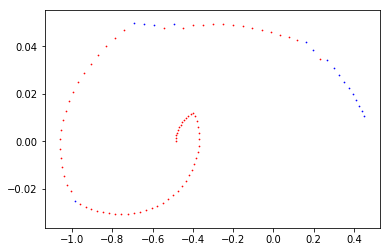

In [11]:
def draw_trajs(trajs, colors = None):
    if colors is None:
            colors = ['r'] * len(trajs)
    for i_traj in range(len(trajs)):
        poss = [np.clip(xy[0][0], -1.2, 0.6) for xy in trajs[i_traj]]
        vs = [np.clip(xy[0][1], -0.07, 0.07)for xy in trajs[i_traj]]
        _ = plt.scatter(poss, vs, s = 0.5, c = colors[i_traj])
    plt.show()
    
draw_trajs([nn_trajs[0], mpc_trajs[0]], ['r', 'b'])


[-0.48535774  0.        ]
Reached at step 85!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.06


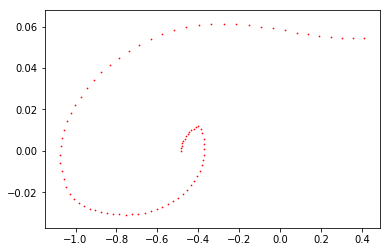

Reached at step 85!!!!!!


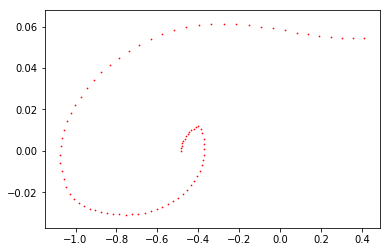

In [12]:
def agent_run(agent, x0s):
    agent_trajs = []
    for i_x0 in range(len(x0s)):
        agent_trajs.append([])
        x = x0s[i_x0]
        done = False
        for step in range(200):
            u = agent.run(tensor([x]).cuda())[0]
            #u = policy_net(tensor(x).unsqueeze(0).to(dtype)).detach().cpu().numpy()[0]
            agent_trajs[-1].append([x[:], u])
            x = dynamics.f(x, u, step)[0]
            if x[0] >= 0.45 and done is False:
                done = True
                print("Reached at step {}!!!!!!".format(step + 1))
                break
    return agent_trajs

x0s[0] = trajs[0][0][0]

agent_trajs = []
agent_trajs = replay(agent, x0s)
draw_trajs(agent_trajs)

agent_trajs = []
agent_trajs = agent_run(agent, x0s)
draw_trajs(agent_trajs)

95
[Epoch 1] avg_loss: 1.180
[Epoch 51] avg_loss: 0.442
[Epoch 101] avg_loss: 0.364
[Epoch 151] avg_loss: 0.231
[Epoch 201] avg_loss: 0.216
[Epoch 251] avg_loss: 0.245
[Epoch 301] avg_loss: 0.232
[Epoch 351] avg_loss: 0.177
[Epoch 401] avg_loss: 0.096
[Epoch 451] avg_loss: 0.099
[Epoch 501] avg_loss: 0.082
[Epoch 551] avg_loss: 0.079
[Epoch 601] avg_loss: 0.078
[Epoch 651] avg_loss: 0.077
[Epoch 701] avg_loss: 0.076
[Epoch 751] avg_loss: 0.075
[Epoch 801] avg_loss: 0.075
[Epoch 851] avg_loss: 0.069
[Epoch 901] avg_loss: 0.044
[Epoch 951] avg_loss: 0.044
Finished Training
Reached at step 100!!!!!!


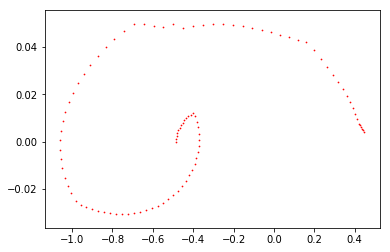

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99351585]


/home/depend/virtualenv_py3/lib/python3.5/site-packages/ipykernel_launcher.py:42: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


[-0.48415365  0.00120409]
>>>>>Step 1 at [-0.48415365  0.00120409]
NN verification via simulation
Utilize NN output [1.99429294]
[-0.48175326  0.00240039]
>>>>>Step 2 at [-0.48175326  0.00240039]
NN verification via simulation
Utilize NN output [1.99460244]
[-0.47817399  0.00357927]
>>>>>Step 3 at [-0.47817399  0.00357927]
NN verification via simulation
Utilize NN output [1.99535851]
[-0.47344131  0.00473268]
>>>>>Step 4 at [-0.47344131  0.00473268]
NN verification via simulation
Utilize NN output [1.995719]
[-0.46758982  0.00585149]
>>>>>Step 5 at [-0.46758982  0.00585149]
NN verification via simulation
Utilize NN output [1.99684488]
[-0.46066115  0.00692867]
>>>>>Step 6 at [-0.46066115  0.00692867]
NN verification via simulation
Utilize NN output [1.99800336]
[-0.45270471  0.00795644]
>>>>>Step 7 at [-0.45270471  0.00795644]
NN verification via simulation
Utilize NN output [1.99819799]
[-0.44377868  0.00892603]
>>>>>Step 8 at [-0.44377868  0.00892603]
NN verification via simulation
U

NN verification via simulation
Utilize NN output [0.15221154]
[-0.5480778  0.0482045]
>>>>>Step 67 at [-0.5480778  0.0482045]
NN verification via simulation
Utilize NN output [1.71157345]
[-0.49862251  0.04945528]
>>>>>Step 68 at [-0.49862251  0.04945528]
NN verification via simulation
Utilize NN output [0.14124476]
[-0.45064251  0.04798001]
>>>>>Step 69 at [-0.45064251  0.04798001]
NN verification via simulation
Utilize NN output [1.86060745]
[-0.40191441  0.0487281 ]
>>>>>Step 70 at [-0.40191441  0.0487281 ]
NN verification via simulation
Utilize NN output [1.99840762]
[-0.35258119  0.04933322]
>>>>>Step 71 at [-0.35258119  0.04933322]
NN verification via simulation
Utilize NN output [1.99745]
[-0.3029789   0.04960229]
>>>>>Step 72 at [-0.3029789   0.04960229]
NN verification via simulation
Utilize NN output [1.99668773]
[-0.25341803  0.04956086]
>>>>>Step 73 at [-0.25341803  0.04956086]
NN verification via simulation
Utilize NN output [1.99487233]
[-0.20417651  0.04924152]
>>>>>Step

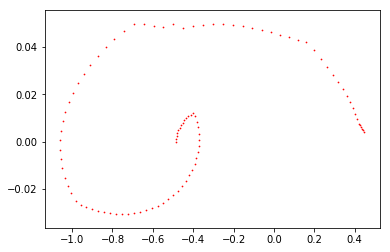

Reached at step 100!!!!!!


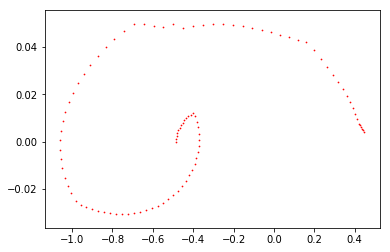

In [13]:
policy_net_temp, _, running_state = pickle.load(open(\
"/home/depend/workspace/MPSC_Guided_Imitation_Learning/PyTorch-RL/assets/learned_models/MountainCarContinuous-v0_ppo.p", "rb"))

agent_temp = NeuralNetwork(input_size = 2, output_size = 1, \
                           model_name = 'mountaincar_ppo_temp', \
                           batch_size = 10)
agent_temp.model = policy_net.to(device)
checkpoint_temp = torch.load('checkpoints/mountaincar_ppo.pt')
agent_temp.model.load_state_dict(checkpoint_temp['model_state_dict'], strict = False)
agent_temp.optimizer = torch.optim.Adam(agent_temp.model.parameters(), lr = 0.0001)

def train_pipeline(agent, x0s = None, train_trajs = None, paths = None, num_epoch = 51):

    if x0s is None:
        x0s = []
        for i_traj in range(len(train_trajs)):
            x0s.append(train_trajs[i_traj][0][0])
    
    X = []
    Y = []
    
    if train_trajs is not None and train_trajs is not []:
        #print(len(train_trajs))
        for i_traj in range(len(train_trajs)):
            for i_xy in range(len(train_trajs[i_traj])):
                X.append([x for x in train_trajs[i_traj][i_xy][0]])
                Y.append([y for y in train_trajs[i_traj][i_xy][1]])
    agent.data_process(X = X, Y = Y, paths = paths)
    
    agent.train(num_epoch = num_epoch)
    #for i in range(len(X)):
    #    print(agent_.run([X[i]]), Y[i])

    agent_temp_trajs = agent_run(agent, x0s)    
    draw_trajs(agent_temp_trajs)
    #replay(agent, x0s)
    
    # Random initial action path.

    J_hist = []

    trajs_, nn_trajs_, mpc_trajs_, train_trajs_ = MPSC(agent, x0s)
    draw_trajs([nn_trajs_[0], mpc_trajs_[0]], ['r', 'b'])
    return trajs_, nn_trajs_, mpc_trajs_, train_trajs_ 


trajs_, nn_trajs_, mpc_trajs_, train_trajs_ = train_pipeline(agent_temp, \
                                                             x0s, \
                                                             train_trajs = train_trajs, \
                                                             paths = None, \
                                                             num_epoch = 1000)

agent_trajs = agent_run(agent_temp, x0s)
draw_trajs(agent_trajs)

78
[Epoch 1] avg_loss: 0.054
[Epoch 51] avg_loss: 0.051
[Epoch 101] avg_loss: 0.051
[Epoch 151] avg_loss: 0.051
[Epoch 201] avg_loss: 0.051
[Epoch 251] avg_loss: 0.054
[Epoch 301] avg_loss: 0.054
[Epoch 351] avg_loss: 0.051
[Epoch 401] avg_loss: 0.051
[Epoch 451] avg_loss: 0.054
[Epoch 501] avg_loss: 0.054
[Epoch 551] avg_loss: 0.054
[Epoch 601] avg_loss: 0.054
[Epoch 651] avg_loss: 0.054
[Epoch 701] avg_loss: 0.050
[Epoch 751] avg_loss: 0.050
[Epoch 801] avg_loss: 0.050
[Epoch 851] avg_loss: 0.053
[Epoch 901] avg_loss: 0.054
[Epoch 951] avg_loss: 0.050
Finished Training
Reached at step 77!!!!!!


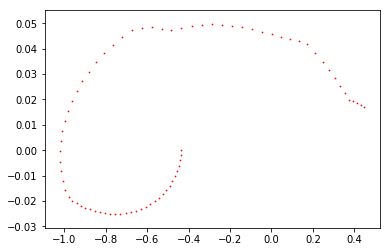

>>>>>Step 0 at [-0.43528484  0.        ]
NN verification via simulation


/home/depend/virtualenv_py3/lib/python3.5/site-packages/ipykernel_launcher.py:42: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Utilize NN output [0.16930931]
[-0.43718551 -0.00190067]
>>>>>Step 1 at [-0.43718551 -0.00190067]
NN verification via simulation
Utilize NN output [0.00610249]
[-0.44121789 -0.00403238]
>>>>>Step 2 at [-0.44121789 -0.00403238]
NN verification via simulation
Utilize NN output [0.00138533]
[-0.44735978 -0.00614189]
>>>>>Step 3 at [-0.44735978 -0.00614189]
NN verification via simulation
Utilize NN output [0.0013908]
[-0.4555664  -0.00820662]
>>>>>Step 4 at [-0.4555664  -0.00820662]
NN verification via simulation
Utilize NN output [0.0031601]
[-0.46577499 -0.01020859]
>>>>>Step 5 at [-0.46577499 -0.01020859]
NN verification via simulation
Utilize NN output [0.00855873]
[-0.47790225 -0.01212726]
>>>>>Step 6 at [-0.47790225 -0.01212726]
NN verification via simulation
Utilize NN output [0.0127382]
[-0.49185205 -0.0139498 ]
>>>>>Step 7 at [-0.49185205 -0.0139498 ]
NN verification via simulation
Utilize NN output [0.01086229]
[-0.5075233  -0.01567125]
>>>>>Step 8 at [-0.5075233  -0.01567125]
NN

[0.17362307 0.04193636]
>>>>>Step 65 at [0.17362307 0.04193636]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-2.64990313] [ 0.43944191 -0.00132888]
Utilize NN output [0.03785673]
[0.21194775 0.03832468]
>>>>>Step 66 at [0.21194775 0.03832468]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-23.24998087] [ 0.43906547 -0.00045689]
Utilize NN output [0.00282675]
[0.24676524 0.03481749]
>>>>>Step 67 at [0.24676524 0.03481749]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-39.97319058] [4.39667629e-01 4.08745423e-04]
Utilize NN output [0.00776828]
[0.27824872 0.03148347]
>>>>>Step 68 at [0.27824872 0.03148347]
NN verification via simulation
MPC feasibility verification
iteration 0 accepted [-53.48358653] [0.44116344 0.00127878]
Utilize NN output [0.01003176]
[0.30656882 0.02832011]
>>>>>Step 69 at [0.30656882 0.02832011]
NN verification via simulation
MPC feasibility verification
itera

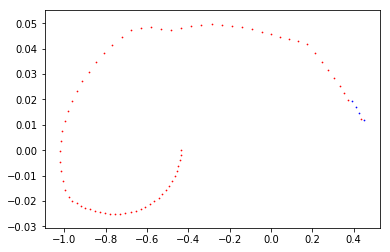

Reached at step 77!!!!!!


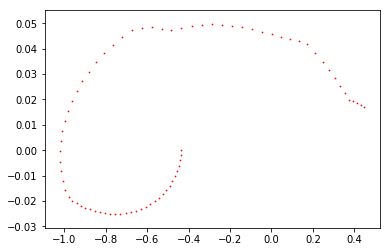

In [14]:
trajs_, nn_trajs_, mpc_trajs_, train_trajs_ = \
train_pipeline(agent_temp, \
               x0s, \
               train_trajs = train_trajs_, \
               paths = None, \
               num_epoch = 1000)
#draw_trajs(train_trajs_)
agent_trajs = agent_run(agent_temp, x0s)
draw_trajs(agent_trajs)
#agent_trajs = replay(agent_temp, x0s)

In [14]:
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch

from torch.autograd import Variable
from scipy.linalg import block_diag

from scipy.sparse import coo_matrix, vstack, linalg
from cvxopt import spmatrix, spdiag, matrix, solvers, sparse

epoch_init = 0
num_epoch = 10
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

x0s = []
for i_traj in range(len(trajs)):
    x0s.append(trajs[i_traj][0][0]) 


def numpy_sparse_to_spmatrix(X):
    X = coo_matrix(X)
    coo = X.tocoo()
    SP = spmatrix(coo.data.tolist(), coo.row.tolist(), coo.col.tolist(), size = coo.shape)
    return SP

Reached at step 85!!!!!!
Done. 1 paths


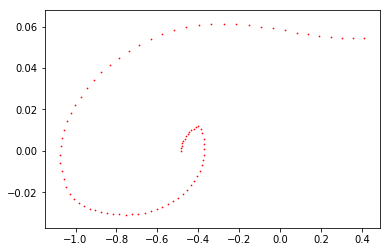

In [15]:
policy_net_0, _, running_state = pickle.load(open(\
"/home/depend/workspace/MPSC_Guided_Imitation_Learning/PyTorch-RL/assets/learned_models/MountainCarContinuous-v0_ppo.p", "rb"))

agent_0 = NeuralNetwork(input_size = 2, output_size = 1, \
                        model_name = 'mountaincar_ppo', \
                        batch_size = 10)
agent_0.model = policy_net_0.to(device)

agent_trajs = agent_run(agent_0, x0s) 
print("Done. {} paths".format(len(agent_trajs)))
draw_trajs(agent_trajs)
#replay(agent_0, agent_trajs)


Reached at step 100!!!!!!
Done. 1 paths


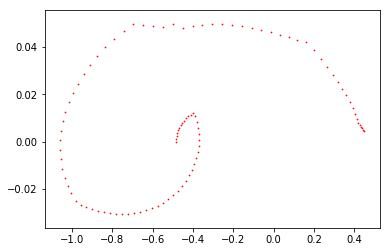

'\n# Run MPSC guided controller and generate safe trajectory\ntraj, nn_traj, mpc_traj, train_traj = MPSC(agent, x0s)\ndraw_agent_traj(traj)\ndraw_str(nn_traj, mpc_traj)\n\n# Collect training trajectory\ntrain_traj_aggr = [i for i in train_traj[:]] * 100\nitr = 0\n\nwhile itr < 1:\n    train_traj = train_temp(agent, x0s, train_traj_aggr, paths = None)\n    train_traj_aggr = train_traj_aggr + [i for i in train_traj[:]] * 100\n    itr += 1\n'

In [16]:
policy_net_1, _, running_state = pickle.load(open(\
"/home/depend/workspace/MPSC_Guided_Imitation_Learning/PyTorch-RL/assets/learned_models/MountainCarContinuous-v0_ppo.p", "rb"))

agent_1 = NeuralNetwork(input_size = 2, \
                      output_size = 1, \
                      model_name = 'mountaincar_ppo_MPSC', \
                      batch_size = 10)
agent_1.model = policy_net_1.to(device)
checkpoint_1 = torch.load('checkpoints/mountaincar_ppo_temp.pt')
agent_1.model.load_state_dict(checkpoint_1['model_state_dict'], strict = False)
agent_1.optimizer = torch.optim.Adam(agent_1.model.parameters(), lr = 0.0001)

agent_trajs = agent_run(agent_1, x0s) 
print("Done. {} paths".format(len(agent_trajs)))
draw_trajs(agent_trajs)
#replay(agent_1, agent_trajs)


'''
# Run MPSC guided controller and generate safe trajectory
traj, nn_traj, mpc_traj, train_traj = MPSC(agent, x0s)
draw_agent_traj(traj)
draw_str(nn_traj, mpc_traj)

# Collect training trajectory
train_traj_aggr = [i for i in train_traj[:]] * 100
itr = 0

while itr < 1:
    train_traj = train_temp(agent, x0s, train_traj_aggr, paths = None)
    train_traj_aggr = train_traj_aggr + [i for i in train_traj[:]] * 100
    itr += 1
'''


>>>>>>>>>>>>>>>>>>>>
Start epoch 0
Optimize rajectory 0
Finished iteration 0 [Safe]
Found new optimal solution. Load QP parameters.
Found new optimal solution. Load QP parameters.
Found new optimal solution. Load QP parameters.
Found new optimal solution. Load QP parameters.
Finished iteration 10 [Safe]
Finished iteration 20 [Safe]
Finished iteration 30 [Safe]
Finished iteration 40 [Safe]
Finished iteration 50 [Safe]
Finished iteration 60 [Safe]
Finished iteration 70 [Safe]
Finished iteration 80 [Safe]
Finished iteration 90 [Safe]


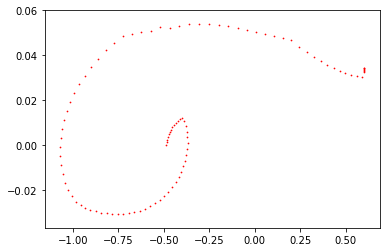

100
[Epoch 1] avg_loss: 0.275
[Epoch 51] avg_loss: 0.251
[Epoch 101] avg_loss: 0.248
[Epoch 151] avg_loss: 0.247
[Epoch 201] avg_loss: 0.247
[Epoch 251] avg_loss: 0.247
[Epoch 301] avg_loss: 0.247
[Epoch 351] avg_loss: 0.100
[Epoch 401] avg_loss: 0.096
[Epoch 451] avg_loss: 0.095
[Epoch 501] avg_loss: 0.095
[Epoch 551] avg_loss: 0.095
[Epoch 601] avg_loss: 0.094
[Epoch 651] avg_loss: 0.094
[Epoch 701] avg_loss: 0.094
[Epoch 751] avg_loss: 0.094
[Epoch 801] avg_loss: 0.094
[Epoch 851] avg_loss: 0.094
[Epoch 901] avg_loss: 0.094
[Epoch 951] avg_loss: 0.094
Finished Training
Reached at step 89!!!!!!


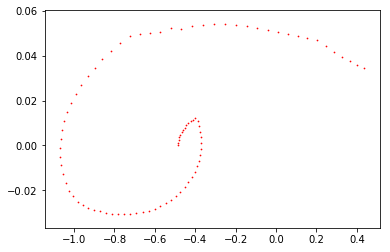

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99655565]
[-0.48414909  0.00120865]
>>>>>Step 1 at [-0.48414909  0.00120865]
NN verification via simulation
Utilize NN output [1.99710793]
[-0.48173995  0.00240913]
>>>>>Step 2 at [-0.48173995  0.00240913]
NN verification via simulation
Utilize NN output [1.99759711]
[-0.47814754  0.00359241]
>>>>>Step 3 at [-0.47814754  0.00359241]
NN verification via simulation
Utilize NN output [1.99793198]
[-0.47339806  0.00474948]
>>>>>Step 4 at [-0.47339806  0.00474948]
NN verification via simulation
Utilize NN output [1.99750126]
[-0.46752741  0.00587065]
>>>>>Step 5 at [-0.46752741  0.00587065]
NN verification via simulation
Utilize NN output [1.9965739]


/home/depend/virtualenv_py3/lib/python3.5/site-packages/ipykernel_launcher.py:42: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


[-0.46058045  0.00694696]
>>>>>Step 6 at [-0.46058045  0.00694696]
NN verification via simulation
Utilize NN output [1.99650396]
[-0.45260857  0.00797189]
>>>>>Step 7 at [-0.45260857  0.00797189]
NN verification via simulation
Utilize NN output [1.99716236]
[-0.44366935  0.00893922]
>>>>>Step 8 at [-0.44366935  0.00893922]
NN verification via simulation
Utilize NN output [1.99752094]
[-0.43382759  0.00984176]
>>>>>Step 9 at [-0.43382759  0.00984176]
NN verification via simulation
Utilize NN output [1.99726192]
[-0.42315512  0.01067248]
>>>>>Step 10 at [-0.42315512  0.01067248]
NN verification via simulation
Utilize NN output [1.99399756]
[-0.41173362  0.01142149]
>>>>>Step 11 at [-0.41173362  0.01142149]
NN verification via simulation
Utilize NN output [1.93427797]
[-0.39973404  0.01199958]
>>>>>Step 12 at [-0.39973404  0.01199958]
NN verification via simulation
Utilize NN output [0.8736833]
[-0.38883169  0.01090235]
>>>>>Step 13 at [-0.38883169  0.01090235]
NN verification via simulat

NN verification via simulation
Utilize NN output [1.99628055]
[-0.19901357  0.05390039]
>>>>>Step 74 at [-0.19901357  0.05390039]
NN verification via simulation
Utilize NN output [1.99558454]
[-0.14568732  0.05332626]
>>>>>Step 75 at [-0.14568732  0.05332626]
NN verification via simulation
Utilize NN output [1.99503642]
[-0.0931335   0.05255381]
>>>>>Step 76 at [-0.0931335   0.05255381]
NN verification via simulation
Utilize NN output [1.99502547]
[-0.0414902  0.0516433]
>>>>>Step 77 at [-0.0414902  0.0516433]
NN verification via simulation
Utilize NN output [1.99459511]
[0.00916433 0.05065453]
>>>>>Step 78 at [0.00916433 0.05065453]
NN verification via simulation
Utilize NN output [1.99299447]
[0.0588093  0.04964497]
>>>>>Step 79 at [0.0588093  0.04964497]
NN verification via simulation
Utilize NN output [1.99195035]
[0.107481  0.0486717]
>>>>>Step 80 at [0.107481  0.0486717]
NN verification via simulation
Utilize NN output [1.99137006]
[0.1552686 0.0477876]
>>>>>Step 81 at [0.1552686

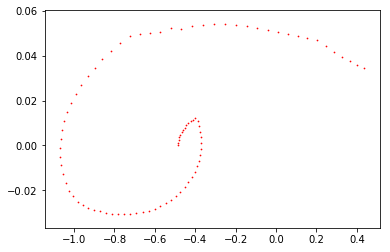

No intervention. Agent is clear.
[-0.48535774  0.        ]
Reached at step 89!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.05


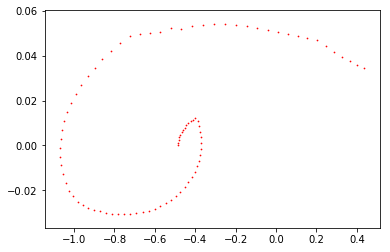

<<<<<<<<<<<<<<<<<<<<
Finished epoch 0




>>>>>>>>>>>>>>>>>>>>
Start epoch 1
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 30 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 40 [Safe]
Finished iteration 50 [Safe]
Finished iteration 60 [Safe]
Finished iteration 70 [Safe]
Finished iteration 80 [Safe]
Finished iteration 90 [Safe]


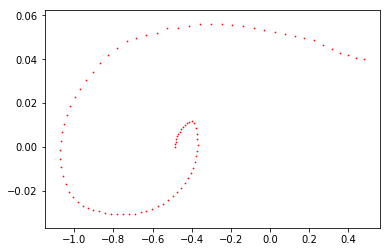

89
[Epoch 1] avg_loss: 0.006
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.001
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 88!!!!!!


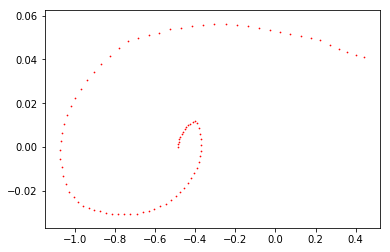

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99773877]
[-0.48414731  0.00121043]
>>>>>Step 1 at [-0.48414731  0.00121043]
NN verification via simulation
Utilize NN output [1.99810006]
[-0.48173493  0.00241238]
>>>>>Step 2 at [-0.48173493  0.00241238]
NN verification via simulation
Utilize NN output [1.99830775]
[-0.47813824  0.00359669]
>>>>>Step 3 at [-0.47813824  0.00359669]
NN verification via simulation
Utilize NN output [1.99856454]
[-0.4733836   0.00475464]
>>>>>Step 4 at [-0.4733836   0.00475464]
NN verification via simulation
Utilize NN output [1.99835411]
[-0.46750662  0.00587698]
>>>>>Step 5 at [-0.46750662  0.00587698]
NN verification via simulation
Utilize NN output [1.9977607]
[-0.46055171  0.00695491]
>>>>>Step 6 at [-0.46055171  0.00695491]
NN verification via simulation
Utilize NN output [1.99767917]
[-0.45257031  0.00798139]
>>>>>Step 7 at [-0.45257031  0.00798139]
NN verification via simulation
Utilize NN output [1.99812

NN verification via simulation
Utilize NN output [1.27416747]
[-0.57967517  0.05214868]
>>>>>Step 67 at [-0.57967517  0.05214868]
NN verification via simulation
Utilize NN output [1.96787389]
[-0.52565609  0.05401909]
>>>>>Step 68 at [-0.52565609  0.05401909]
NN verification via simulation
Utilize NN output [1.05434952]
[-0.47154004  0.05411604]
>>>>>Step 69 at [-0.47154004  0.05411604]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 4.024357661538173e-86 [-0.00771021 -0.0105701 ]
Utilize NN output [1.98303578]
[-0.4163383   0.05520174]
>>>>>Step 70 at [-0.4163383   0.05520174]
NN verification via simulation
MPC feasibility verification
iteration 0 converged [4.21050313e-86] [ 0.02995276 -0.01179593]
Utilize NN output [1.99728184]
[-0.36043129  0.05590702]
>>>>>Step 71 at [-0.36043129  0.05590702]
NN verification via simulation
MPC feasibility verification
iteration 0 converged [4.36268284e-86] [ 0.06981129 -0.01251808]
Utilize NN output [1.99725875]
[-0.

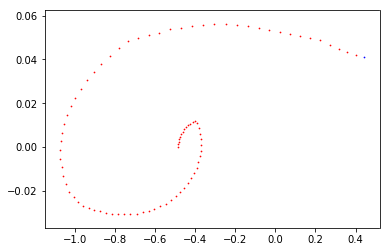

Intervention identified. Retrain agent in the pipeline.
88
[Epoch 1] avg_loss: 0.010
[Epoch 51] avg_loss: 0.003
[Epoch 101] avg_loss: 0.003
[Epoch 151] avg_loss: 0.002
[Epoch 201] avg_loss: 0.002
[Epoch 251] avg_loss: 0.002
[Epoch 301] avg_loss: 0.001
[Epoch 351] avg_loss: 0.001
[Epoch 401] avg_loss: 0.001
[Epoch 451] avg_loss: 0.001
[Epoch 501] avg_loss: 0.001
[Epoch 551] avg_loss: 0.001
[Epoch 601] avg_loss: 0.001
[Epoch 651] avg_loss: 0.001
[Epoch 701] avg_loss: 0.001
[Epoch 751] avg_loss: 0.001
[Epoch 801] avg_loss: 0.001
[Epoch 851] avg_loss: 0.001
[Epoch 901] avg_loss: 0.001
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 88!!!!!!


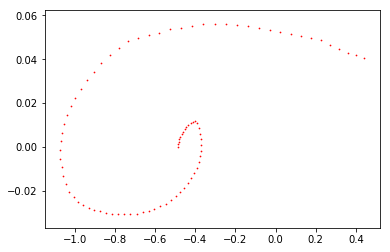

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99771162]
[-0.48414735  0.00121039]
>>>>>Step 1 at [-0.48414735  0.00121039]
NN verification via simulation
Utilize NN output [1.99869221]
[-0.48173412  0.00241323]
>>>>>Step 2 at [-0.48173412  0.00241323]
NN verification via simulation
Utilize NN output [1.99908628]
[-0.47813542  0.0035987 ]
>>>>>Step 3 at [-0.47813542  0.0035987 ]
NN verification via simulation
Utilize NN output [1.99933236]
[-0.47337764  0.00475778]
>>>>>Step 4 at [-0.47337764  0.00475778]
NN verification via simulation
Utilize NN output [1.9994426]
[-0.46749593  0.00588171]
>>>>>Step 5 at [-0.46749593  0.00588171]
NN verification via simulation
Utilize NN output [1.99940473]
[-0.4605339   0.00696203]
>>>>>Step 6 at [-0.4605339   0.00696203]
NN verification via simulation
Utilize NN output [1.99935201]
[-0.45254302  0.00799089]
>>>>>Step 7 at [-0.45254302  0.00799089]
NN verification via simulation
Utilize NN output [1.99936

NN verification via simulation
Utilize NN output [1.27936705]
[-0.57911637  0.05215209]
>>>>>Step 67 at [-0.57911637  0.05215209]
NN verification via simulation
Utilize NN output [1.96839973]
[-0.52509723  0.05401915]
>>>>>Step 68 at [-0.52509723  0.05401915]
NN verification via simulation
Utilize NN output [1.03304059]
[-0.47101728  0.05407995]
>>>>>Step 69 at [-0.47101728  0.05407995]
NN verification via simulation
Utilize NN output [1.98397201]
[-0.4158541   0.05516318]
>>>>>Step 70 at [-0.4158541   0.05516318]
NN verification via simulation
Utilize NN output [1.9929681]
[-0.35999555  0.05585854]
>>>>>Step 71 at [-0.35999555  0.05585854]
NN verification via simulation
Utilize NN output [1.99306367]
[-0.30382576  0.05616979]
>>>>>Step 72 at [-0.30382576  0.05616979]
NN verification via simulation
Utilize NN output [1.99329937]
[-0.24769747  0.05612829]
>>>>>Step 73 at [-0.24769747  0.05612829]
NN verification via simulation
Utilize NN output [1.99218378]
[-0.19192185  0.05577562]
>>>

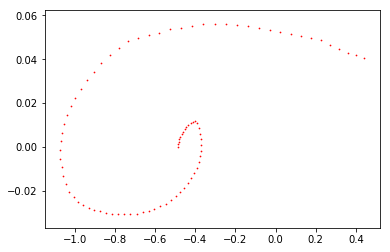

No intervention. Agent is clear.
[-0.48535774  0.        ]
Reached at step 88!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.06


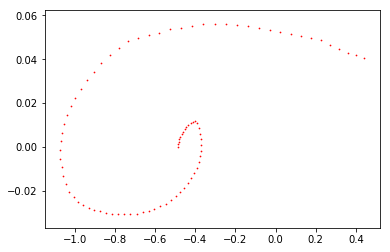

<<<<<<<<<<<<<<<<<<<<
Finished epoch 1




>>>>>>>>>>>>>>>>>>>>
Start epoch 2
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Safe]
Finished iteration 60 [Safe]
Finished iteration 70 [Safe]
Finished iteration 80 [Safe]
Finished iteration 90 [Safe]


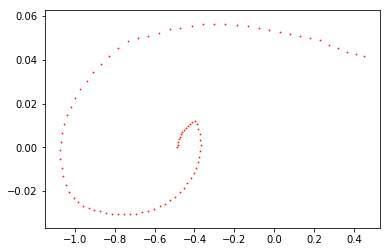

88
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 88!!!!!!


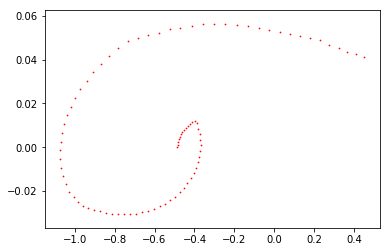

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99790617]
[-0.48414706  0.00121068]
>>>>>Step 1 at [-0.48414706  0.00121068]
NN verification via simulation
Utilize NN output [1.99868654]
[-0.48173355  0.00241351]
>>>>>Step 2 at [-0.48173355  0.00241351]
NN verification via simulation
Utilize NN output [1.99902657]
[-0.47813466  0.00359889]
>>>>>Step 3 at [-0.47813466  0.00359889]
NN verification via simulation
Utilize NN output [1.99929389]
[-0.47337676  0.0047579 ]
>>>>>Step 4 at [-0.47337676  0.0047579 ]
NN verification via simulation
Utilize NN output [1.9993905]
[-0.46749501  0.00588175]
>>>>>Step 5 at [-0.46749501  0.00588175]
NN verification via simulation
Utilize NN output [1.99934417]
[-0.46053304  0.00696197]
>>>>>Step 6 at [-0.46053304  0.00696197]
NN verification via simulation
Utilize NN output [1.99936515]
[-0.4525422   0.00799084]
>>>>>Step 7 at [-0.4525422   0.00799084]
NN verification via simulation
Utilize NN output [1.99946

[-0.68224662  0.04988962]
>>>>>Step 65 at [-0.68224662  0.04988962]
NN verification via simulation
Utilize NN output [1.06494403]
[-0.63111414  0.05113248]
>>>>>Step 66 at [-0.63111414  0.05113248]
NN verification via simulation
Utilize NN output [1.3287339]
[-0.5786961   0.05241804]
>>>>>Step 67 at [-0.5786961   0.05241804]
NN verification via simulation
Utilize NN output [1.97163888]
[-0.52440925  0.05428685]
>>>>>Step 68 at [-0.52440925  0.05428685]
NN verification via simulation
Utilize NN output [1.07802733]
[-0.46999928  0.05440997]
>>>>>Step 69 at [-0.46999928  0.05440997]
NN verification via simulation
Utilize NN output [1.98500431]
[-0.41451208  0.05548721]
>>>>>Step 70 at [-0.41451208  0.05548721]
NN verification via simulation
Utilize NN output [1.99342961]
[-0.35833835  0.05617373]
>>>>>Step 71 at [-0.35833835  0.05617373]
NN verification via simulation
Utilize NN output [1.99352379]
[-0.30186363  0.05647472]
>>>>>Step 72 at [-0.30186363  0.05647472]
NN verification via sim

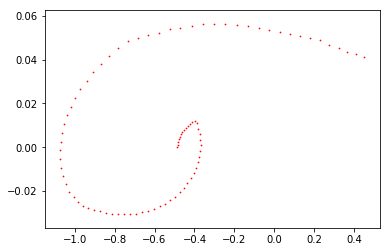

No intervention. Agent is clear.
[-0.48535774  0.        ]
Reached at step 88!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.06


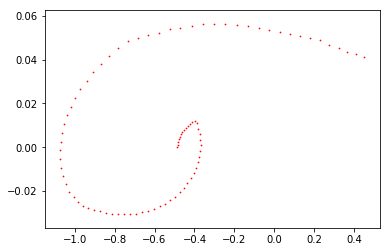

<<<<<<<<<<<<<<<<<<<<
Finished epoch 2




>>>>>>>>>>>>>>>>>>>>
Start epoch 3
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Safe]
Finished iteration 80 [Safe]
Finished iteration 90 [Safe]


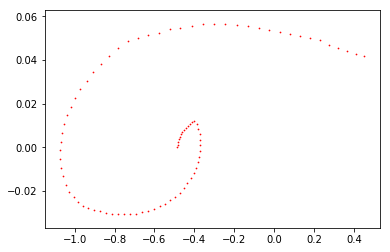

88
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 87!!!!!!


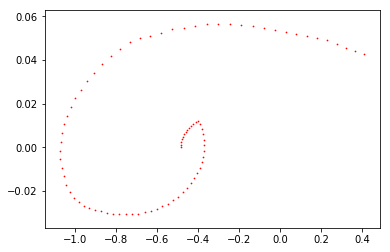

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99800008]
[-0.48414692  0.00121082]
>>>>>Step 1 at [-0.48414692  0.00121082]
NN verification via simulation
Utilize NN output [1.99868437]
[-0.48173327  0.00241365]
>>>>>Step 2 at [-0.48173327  0.00241365]
NN verification via simulation
Utilize NN output [1.9989796]
[-0.47813432  0.00359895]
>>>>>Step 3 at [-0.47813432  0.00359895]
NN verification via simulation
Utilize NN output [1.9992848]
[-0.47337637  0.00475795]
>>>>>Step 4 at [-0.47337637  0.00475795]
NN verification via simulation
Utilize NN output [1.99940797]
[-0.46749455  0.00588182]
>>>>>Step 5 at [-0.46749455  0.00588182]
NN verification via simulation
Utilize NN output [1.99939943]
[-0.46053243  0.00696212]
>>>>>Step 6 at [-0.46053243  0.00696212]
NN verification via simulation
Utilize NN output [1.99946263]
[-0.45254129  0.00799113]
>>>>>Step 7 at [-0.45254129  0.00799113]
NN verification via simulation
Utilize NN output [1.999561

NN verification via simulation
Utilize NN output [1.0717991]
[-0.63245696  0.05113808]
>>>>>Step 66 at [-0.63245696  0.05113808]
NN verification via simulation
Utilize NN output [1.32779219]
[-0.58002519  0.05243177]
>>>>>Step 67 at [-0.58002519  0.05243177]
NN verification via simulation
Utilize NN output [1.96868469]
[-0.52571921  0.05430598]
>>>>>Step 68 at [-0.52571921  0.05430598]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.774286508591146e-86 [-0.03720724 -0.00860804]
Utilize NN output [1.13233108]
[-0.47119883  0.05452038]
>>>>>Step 69 at [-0.47119883  0.05452038]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.976753859558203e-86 [-0.00088772 -0.01024897]
Utilize NN output [1.98210102]
[-0.41559669  0.05560214]
>>>>>Step 70 at [-0.41559669  0.05560214]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 4.1572218677663044e-86 [ 0.03730024 -0.01142639]
Utilize NN output [1.99418553]


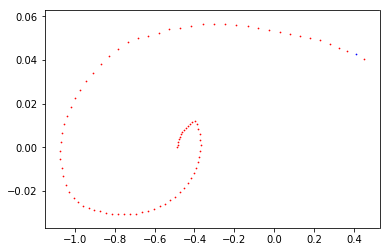

Intervention identified. Retrain agent in the pipeline.
88
[Epoch 1] avg_loss: 0.009
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.001
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 88!!!!!!


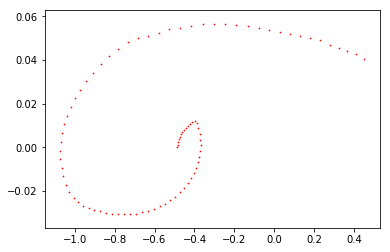

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99798997]
[-0.48414694  0.00121081]
>>>>>Step 1 at [-0.48414694  0.00121081]
NN verification via simulation
Utilize NN output [1.99878119]
[-0.48173316  0.00241378]
>>>>>Step 2 at [-0.48173316  0.00241378]
NN verification via simulation
Utilize NN output [1.99892616]
[-0.47813416  0.003599  ]
>>>>>Step 3 at [-0.47813416  0.003599  ]
NN verification via simulation
Utilize NN output [1.99921225]
[-0.47337626  0.00475789]
>>>>>Step 4 at [-0.47337626  0.00475789]
NN verification via simulation
Utilize NN output [1.99932704]
[-0.46749463  0.00588164]
>>>>>Step 5 at [-0.46749463  0.00588164]
NN verification via simulation
Utilize NN output [1.99936209]
[-0.46053275  0.00696188]
>>>>>Step 6 at [-0.46053275  0.00696188]
NN verification via simulation
Utilize NN output [1.99950972]
[-0.45254178  0.00799097]
>>>>>Step 7 at [-0.45254178  0.00799097]
NN verification via simulation
Utilize NN output [1.9996

NN verification via simulation
Utilize NN output [1.13671417]
[-0.47086646  0.05451702]
>>>>>Step 69 at [-0.47086646  0.05451702]
NN verification via simulation
Utilize NN output [1.98322876]
[-0.41526845  0.05559801]
>>>>>Step 70 at [-0.41526845  0.05559801]
NN verification via simulation
Utilize NN output [1.99454075]
[-0.35897687  0.05629157]
>>>>>Step 71 at [-0.35897687  0.05629157]
NN verification via simulation
Utilize NN output [1.99484798]
[-0.30237811  0.05659876]
>>>>>Step 72 at [-0.30237811  0.05659876]
NN verification via simulation
Utilize NN output [1.99483079]
[-0.24582712  0.056551  ]
>>>>>Step 73 at [-0.24582712  0.056551  ]
NN verification via simulation
Utilize NN output [1.99249122]
[-0.18963779  0.05618932]
>>>>>Step 74 at [-0.18963779  0.05618932]
NN verification via simulation
Utilize NN output [1.99107851]
[-0.13406807  0.05556972]
>>>>>Step 75 at [-0.13406807  0.05556972]
NN verification via simulation
Utilize NN output [1.99055679]
[-0.07931302  0.05475506]
>>

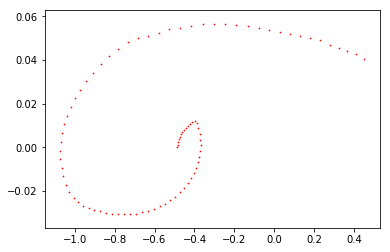

No intervention. Agent is clear.
[-0.48535774  0.        ]
Reached at step 88!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.06


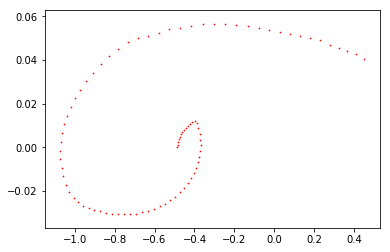

<<<<<<<<<<<<<<<<<<<<
Finished epoch 3




>>>>>>>>>>>>>>>>>>>>
Start epoch 4
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Safe]
Finished iteration 80 [Safe]
Finished iteration 90 [Safe]


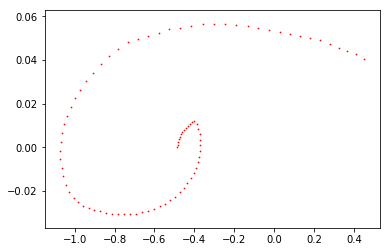

88
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 87!!!!!!


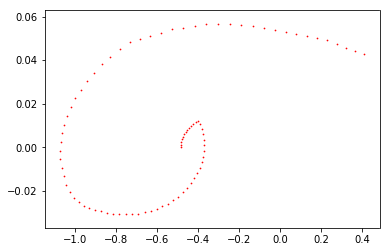

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.9979712]
[-0.48414696  0.00121078]
>>>>>Step 1 at [-0.48414696  0.00121078]
NN verification via simulation
Utilize NN output [1.9988087]
[-0.48173317  0.00241379]
>>>>>Step 2 at [-0.48173317  0.00241379]
NN verification via simulation
Utilize NN output [1.9989661]
[-0.4781341   0.00359907]
>>>>>Step 3 at [-0.4781341   0.00359907]
NN verification via simulation
Utilize NN output [1.99927031]
[-0.47337605  0.00475805]
>>>>>Step 4 at [-0.47337605  0.00475805]
NN verification via simulation
Utilize NN output [1.99941106]
[-0.46749412  0.00588192]
>>>>>Step 5 at [-0.46749412  0.00588192]
NN verification via simulation
Utilize NN output [1.99947945]
[-0.46053179  0.00696234]
>>>>>Step 6 at [-0.46053179  0.00696234]
NN verification via simulation
Utilize NN output [1.99961257]
[-0.45254021  0.00799157]
>>>>>Step 7 at [-0.45254021  0.00799157]
NN verification via simulation
Utilize NN output [1.9996961

[-0.7338484   0.04835349]
>>>>>Step 64 at [-0.7338484   0.04835349]
NN verification via simulation
Utilize NN output [1.02835692]
[-0.683978   0.0498704]
>>>>>Step 65 at [-0.683978   0.0498704]
NN verification via simulation
Utilize NN output [1.07676077]
[-0.63283549  0.05114251]
>>>>>Step 66 at [-0.63283549  0.05114251]
NN verification via simulation
Utilize NN output [1.33444002]
[-0.58038662  0.05244886]
>>>>>Step 67 at [-0.58038662  0.05244886]
NN verification via simulation
Utilize NN output [1.96969972]
[-0.52605936  0.05432726]
>>>>>Step 68 at [-0.52605936  0.05432726]
NN verification via simulation
MPC feasibility verification
iteration 0 converged [3.76511283e-86] [-0.03624448 -0.00854378]
Utilize NN output [1.1614198]
[-0.47147151  0.05458785]
>>>>>Step 69 at [-0.47147151  0.05458785]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.966805475944033e-86 [ 0.00015088 -0.01018027]
Utilize NN output [1.98151653]
[-0.41580075  0.05567076]
>>>>>Step

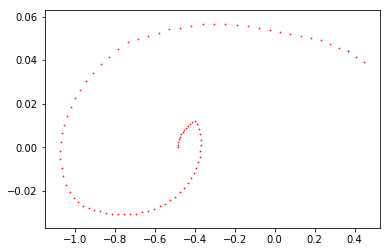

Intervention identified. Retrain agent in the pipeline.
88
[Epoch 1] avg_loss: 0.010
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 88!!!!!!


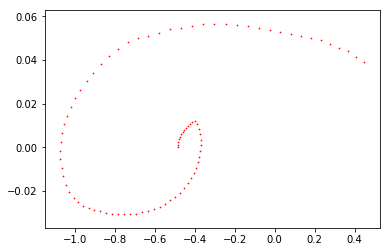

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99794981]
[-0.484147    0.00121075]
>>>>>Step 1 at [-0.484147    0.00121075]
NN verification via simulation
Utilize NN output [1.998765]
[-0.4817333  0.0024137]
>>>>>Step 2 at [-0.4817333  0.0024137]
NN verification via simulation
Utilize NN output [1.99891961]
[-0.47813439  0.00359891]
>>>>>Step 3 at [-0.47813439  0.00359891]
NN verification via simulation
Utilize NN output [1.99913809]
[-0.4733767   0.00475769]
>>>>>Step 4 at [-0.4733767   0.00475769]
NN verification via simulation
Utilize NN output [1.99919945]
[-0.46749546  0.00588125]
>>>>>Step 5 at [-0.46749546  0.00588125]
NN verification via simulation
Utilize NN output [1.99934184]
[-0.46053399  0.00696147]
>>>>>Step 6 at [-0.46053399  0.00696147]
NN verification via simulation
Utilize NN output [1.99957627]
[-0.45254333  0.00799066]
>>>>>Step 7 at [-0.45254333  0.00799066]
NN verification via simulation
Utilize NN output [1.99968529]


[-0.632079    0.05114614]
>>>>>Step 66 at [-0.632079    0.05114614]
NN verification via simulation
Utilize NN output [1.33585049]
[-0.57962977  0.05244924]
>>>>>Step 67 at [-0.57962977  0.05244924]
NN verification via simulation
Utilize NN output [1.9714506]
[-0.5253051   0.05432467]
>>>>>Step 68 at [-0.5253051   0.05432467]
NN verification via simulation
Utilize NN output [1.13833058]
[-0.47076014  0.05454496]
>>>>>Step 69 at [-0.47076014  0.05454496]
NN verification via simulation
Utilize NN output [1.98208638]
[-0.41513668  0.05562346]
>>>>>Step 70 at [-0.41513668  0.05562346]
NN verification via simulation
Utilize NN output [1.99526899]
[-0.35881951  0.05631717]
>>>>>Step 71 at [-0.35881951  0.05631717]
NN verification via simulation
Utilize NN output [1.99554421]
[-0.30219514  0.05662437]
>>>>>Step 72 at [-0.30219514  0.05662437]
NN verification via simulation
Utilize NN output [1.99505862]
[-0.24561928  0.05657586]
>>>>>Step 73 at [-0.24561928  0.05657586]
NN verification via sim

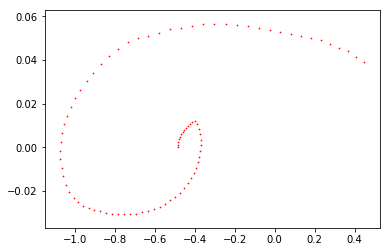

No intervention. Agent is clear.
[-0.48535774  0.        ]
Reached at step 88!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.06


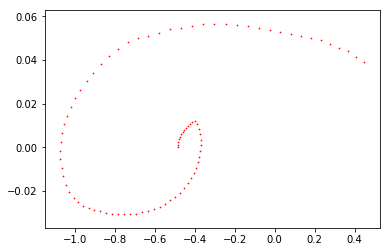

<<<<<<<<<<<<<<<<<<<<
Finished epoch 4




>>>>>>>>>>>>>>>>>>>>
Start epoch 5
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Safe]
Finished iteration 70 [Safe]
Finished iteration 80 [Safe]
Finished iteration 90 [Safe]


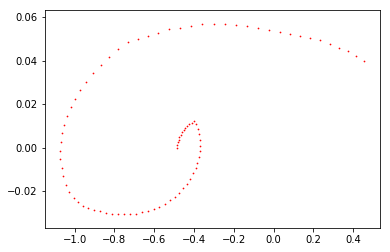

88
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 87!!!!!!


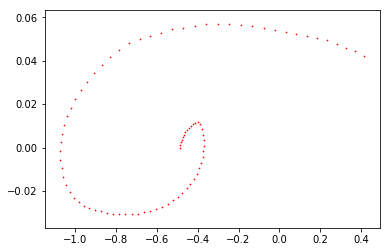

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99818583]
[-0.48414664  0.0012111 ]
>>>>>Step 1 at [-0.48414664  0.0012111 ]
NN verification via simulation
Utilize NN output [1.99897761]
[-0.48173228  0.00241437]
>>>>>Step 2 at [-0.48173228  0.00241437]
NN verification via simulation
Utilize NN output [1.99904925]
[-0.47813251  0.00359977]
>>>>>Step 3 at [-0.47813251  0.00359977]
NN verification via simulation
Utilize NN output [1.99920129]
[-0.47337388  0.00475863]
>>>>>Step 4 at [-0.47337388  0.00475863]
NN verification via simulation
Utilize NN output [1.99924588]
[-0.46749165  0.00588223]
>>>>>Step 5 at [-0.46749165  0.00588223]
NN verification via simulation
Utilize NN output [1.99939876]
[-0.46052914  0.00696251]
>>>>>Step 6 at [-0.46052914  0.00696251]
NN verification via simulation
Utilize NN output [1.99961944]
[-0.4525374   0.00799174]
>>>>>Step 7 at [-0.4525374   0.00799174]
NN verification via simulation
Utilize NN output [1.9997

NN verification via simulation
Utilize NN output [1.1345768]
[-0.63306583  0.05133033]
>>>>>Step 66 at [-0.63306583  0.05133033]
NN verification via simulation
Utilize NN output [1.38723741]
[-0.58034831  0.05271751]
>>>>>Step 67 at [-0.58034831  0.05271751]
NN verification via simulation
Utilize NN output [1.97381184]
[-0.52574651  0.0546018 ]
>>>>>Step 68 at [-0.52574651  0.0546018 ]
NN verification via simulation
Utilize NN output [1.20275553]
[-0.47082447  0.05492204]
>>>>>Step 69 at [-0.47082447  0.05492204]
NN verification via simulation
Utilize NN output [1.98304479]
[-0.41482202  0.05600245]
>>>>>Step 70 at [-0.41482202  0.05600245]
NN verification via simulation
Utilize NN output [1.99551061]
[-0.35812772  0.0566943 ]
>>>>>Step 71 at [-0.35812772  0.0566943 ]
NN verification via simulation
Utilize NN output [1.99576157]
[-0.30113047  0.05699725]
>>>>>Step 72 at [-0.30113047  0.05699725]
NN verification via simulation
Utilize NN output [1.99547356]
[-0.24418738  0.05694309]
>>>

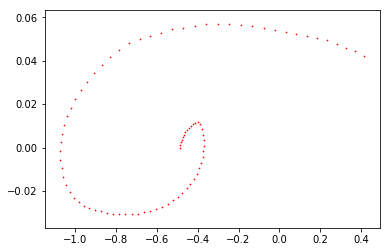

No intervention. Agent is clear.
[-0.48535774  0.        ]
Reached at step 87!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.06


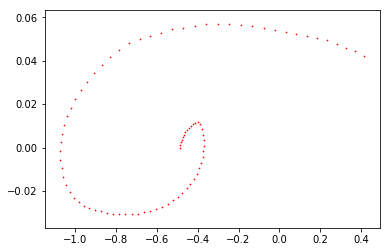

<<<<<<<<<<<<<<<<<<<<
Finished epoch 5




>>>>>>>>>>>>>>>>>>>>
Start epoch 6
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 10 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Safe]
Finished iteration 50 [Safe]
Finished iteration 60 [Safe]
Finished iteration 70 [Safe]
Finished iteration 80 [Safe]
Finished iteration 90 [Safe]


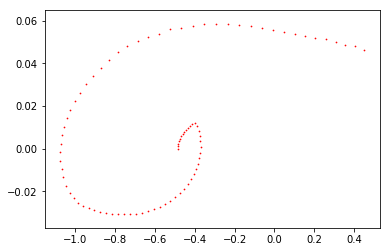

87
[Epoch 1] avg_loss: 0.012
[Epoch 51] avg_loss: 0.002
[Epoch 101] avg_loss: 0.002
[Epoch 151] avg_loss: 0.003
[Epoch 201] avg_loss: 0.002
[Epoch 251] avg_loss: 0.002
[Epoch 301] avg_loss: 0.002
[Epoch 351] avg_loss: 0.003
[Epoch 401] avg_loss: 0.002
[Epoch 451] avg_loss: 0.003
[Epoch 501] avg_loss: 0.002
[Epoch 551] avg_loss: 0.002
[Epoch 601] avg_loss: 0.002
[Epoch 651] avg_loss: 0.003
[Epoch 701] avg_loss: 0.003
[Epoch 751] avg_loss: 0.002
[Epoch 801] avg_loss: 0.002
[Epoch 851] avg_loss: 0.003
[Epoch 901] avg_loss: 0.002
[Epoch 951] avg_loss: 0.002
Finished Training
Reached at step 87!!!!!!


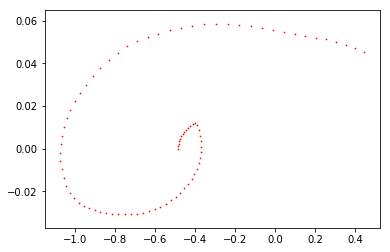

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99858996]
[-0.48414604  0.00121171]
>>>>>Step 1 at [-0.48414604  0.00121171]
NN verification via simulation
Utilize NN output [1.99931845]
[-0.48173056  0.00241548]
>>>>>Step 2 at [-0.48173056  0.00241548]
NN verification via simulation
Utilize NN output [1.99925112]
[-0.47812939  0.00360117]
>>>>>Step 3 at [-0.47812939  0.00360117]
NN verification via simulation
Utilize NN output [1.99928883]
[-0.47336925  0.00476014]
>>>>>Step 4 at [-0.47336925  0.00476014]
NN verification via simulation
Utilize NN output [1.99928971]
[-0.46748548  0.00588378]
>>>>>Step 5 at [-0.46748548  0.00588378]
NN verification via simulation
Utilize NN output [1.99942475]
[-0.46052143  0.00696405]
>>>>>Step 6 at [-0.46052143  0.00696405]
NN verification via simulation
Utilize NN output [1.99963963]
[-0.45252818  0.00799325]
>>>>>Step 7 at [-0.45252818  0.00799325]
NN verification via simulation
Utilize NN output [1.9997

Utilize NN output [1.4161341]
[-0.68822424  0.05030815]
>>>>>Step 65 at [-0.68822424  0.05030815]
NN verification via simulation
Utilize NN output [1.43003456]
[-0.63608593  0.05213831]
>>>>>Step 66 at [-0.63608593  0.05213831]
NN verification via simulation
Utilize NN output [1.59972623]
[-0.58222031  0.05386563]
>>>>>Step 67 at [-0.58222031  0.05386563]
NN verification via simulation
Utilize NN output [1.9816152]
[-0.52644486  0.05577545]
>>>>>Step 68 at [-0.52644486  0.05577545]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.559646545815784e-86 [-0.00478394 -0.00707262]
Utilize NN output [1.51755083]
[-0.46987174  0.05657312]
>>>>>Step 69 at [-0.46987174  0.05657312]
NN verification via simulation
MPC feasibility verification
iteration 0 converged [3.73454263e-86] [ 0.03448429 -0.00848079]
Utilize NN output [1.98902905]
[-0.41221629  0.05765545]
>>>>>Step 70 at [-0.41221629  0.05765545]
NN verification via simulation
MPC feasibility verification
ite

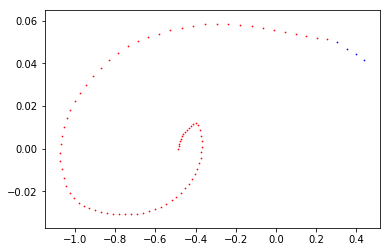

Intervention identified. Retrain agent in the pipeline.
87
[Epoch 1] avg_loss: 0.028
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 87!!!!!!


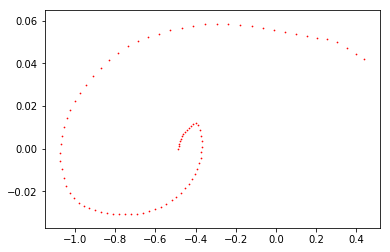

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99852439]
[-0.48414613  0.00121161]
>>>>>Step 1 at [-0.48414613  0.00121161]
NN verification via simulation
Utilize NN output [1.99940352]
[-0.48173063  0.00241551]
>>>>>Step 2 at [-0.48173063  0.00241551]
NN verification via simulation
Utilize NN output [1.99920203]
[-0.4781295   0.00360113]
>>>>>Step 3 at [-0.4781295   0.00360113]
NN verification via simulation
Utilize NN output [1.9990272]
[-0.4733698  0.0047597]
>>>>>Step 4 at [-0.4733698  0.0047597]
NN verification via simulation
Utilize NN output [1.99898677]
[-0.46748691  0.00588289]
>>>>>Step 5 at [-0.46748691  0.00588289]
NN verification via simulation
Utilize NN output [1.9992067]
[-0.46052406  0.00696285]
>>>>>Step 6 at [-0.46052406  0.00696285]
NN verification via simulation
Utilize NN output [1.99946101]
[-0.45253227  0.00799179]
>>>>>Step 7 at [-0.45253227  0.00799179]
NN verification via simulation
Utilize NN output [1.99956518]


Utilize NN output [1.43073301]
[-0.63594818  0.05213958]
>>>>>Step 66 at [-0.63594818  0.05213958]
NN verification via simulation
Utilize NN output [1.60050915]
[-0.58208108  0.0538671 ]
>>>>>Step 67 at [-0.58208108  0.0538671 ]
NN verification via simulation
Utilize NN output [1.98204837]
[-0.52630454  0.05577654]
>>>>>Step 68 at [-0.52630454  0.05577654]
NN verification via simulation
Utilize NN output [1.51699942]
[-0.46973221  0.05657233]
>>>>>Step 69 at [-0.46973221  0.05657233]
NN verification via simulation
Utilize NN output [1.98850134]
[-0.41207937  0.05765284]
>>>>>Step 70 at [-0.41207937  0.05765284]
NN verification via simulation
Utilize NN output [1.99577722]
[-0.35375374  0.05832563]
>>>>>Step 71 at [-0.35375374  0.05832563]
NN verification via simulation
Utilize NN output [1.99585854]
[-0.29515376  0.05859999]
>>>>>Step 72 at [-0.29515376  0.05859999]
NN verification via simulation
Utilize NN output [1.9960491]
[-0.23664203  0.05851173]
>>>>>Step 73 at [-0.23664203  0.05

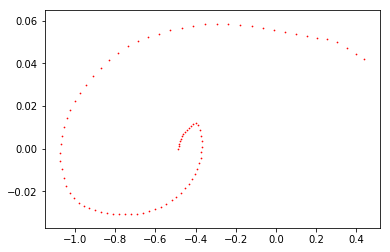

No intervention. Agent is clear.
[-0.48535774  0.        ]
Reached at step 87!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.06


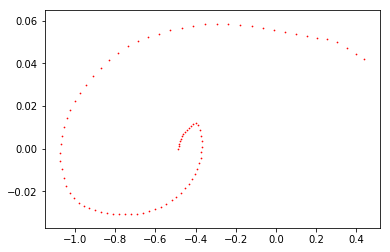

<<<<<<<<<<<<<<<<<<<<
Finished epoch 6




>>>>>>>>>>>>>>>>>>>>
Start epoch 7
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 30 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 40 [Unsafe]
Finished iteration 50 [Safe]
Finished iteration 60 [Safe]
Finished iteration 70 [Safe]
Finished iteration 80 [Safe]
Finished iteration 90 [Safe]


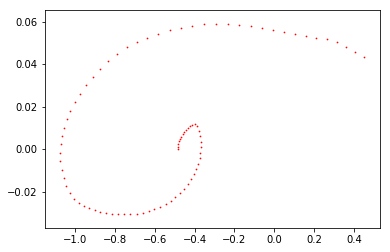

87
[Epoch 1] avg_loss: 0.002
[Epoch 51] avg_loss: 0.001
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.001
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 87!!!!!!


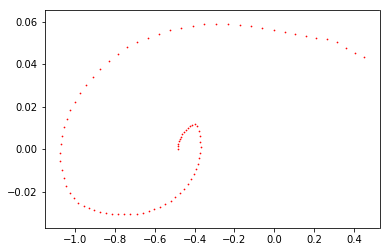

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.9985944]
[-0.48414603  0.00121171]
>>>>>Step 1 at [-0.48414603  0.00121171]
NN verification via simulation
Utilize NN output [1.99946823]
[-0.48173032  0.00241571]
>>>>>Step 2 at [-0.48173032  0.00241571]
NN verification via simulation
Utilize NN output [1.99926214]
[-0.4781289   0.00360141]
>>>>>Step 3 at [-0.4781289   0.00360141]
NN verification via simulation
Utilize NN output [1.9991488]
[-0.47336873  0.00476017]
>>>>>Step 4 at [-0.47336873  0.00476017]
NN verification via simulation
Utilize NN output [1.99920475]
[-0.46748506  0.00588368]
>>>>>Step 5 at [-0.46748506  0.00588368]
NN verification via simulation
Utilize NN output [1.99939053]
[-0.46052116  0.00696389]
>>>>>Step 6 at [-0.46052116  0.00696389]
NN verification via simulation
Utilize NN output [1.9995698]
[-0.45252818  0.00799299]
>>>>>Step 7 at [-0.45252818  0.00799299]
NN verification via simulation
Utilize NN output [1.9996472

NN verification via simulation
Utilize NN output [1.52246338]
[-0.63496249  0.05242469]
>>>>>Step 66 at [-0.63496249  0.05242469]
NN verification via simulation
Utilize NN output [1.67028602]
[-0.5807126  0.0542499]
>>>>>Step 67 at [-0.5807126  0.0542499]
NN verification via simulation
Utilize NN output [1.98573922]
[-0.52455783  0.05615477]
>>>>>Step 68 at [-0.52455783  0.05615477]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.5226246065751256e-86 [ 0.00343094 -0.00679435]
Utilize NN output [1.58835935]
[-0.46751333  0.0570445 ]
>>>>>Step 69 at [-0.46751333  0.0570445 ]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.690904521519709e-86 [ 0.04342538 -0.00813087]
Utilize NN output [1.9914539]
[-0.40940031  0.05811302]
>>>>>Step 70 at [-0.40940031  0.05811302]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.83097127019758e-86 [ 0.08568661 -0.00893008]
Utilize NN output [1.99498884]
[-0.3

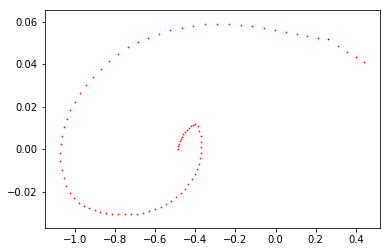

Intervention identified. Retrain agent in the pipeline.
87
[Epoch 1] avg_loss: 0.019
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 87!!!!!!


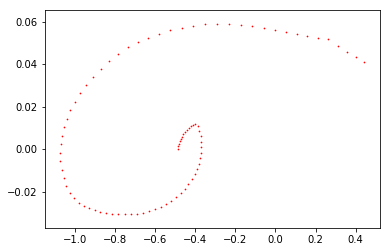

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99863416]
[-0.48414597  0.00121177]
>>>>>Step 1 at [-0.48414597  0.00121177]
NN verification via simulation
Utilize NN output [1.99952188]
[-0.48173012  0.00241585]
>>>>>Step 2 at [-0.48173012  0.00241585]
NN verification via simulation
Utilize NN output [1.99939501]
[-0.47812837  0.00360175]
>>>>>Step 3 at [-0.47812837  0.00360175]
NN verification via simulation
Utilize NN output [1.99933958]
[-0.47336758  0.00476079]
>>>>>Step 4 at [-0.47336758  0.00476079]
NN verification via simulation
Utilize NN output [1.99943032]
[-0.46748295  0.00588463]
>>>>>Step 5 at [-0.46748295  0.00588463]
NN verification via simulation
Utilize NN output [1.99952897]
[-0.46051792  0.00696504]
>>>>>Step 6 at [-0.46051792  0.00696504]
NN verification via simulation
Utilize NN output [1.99959304]
[-0.45252378  0.00799414]
>>>>>Step 7 at [-0.45252378  0.00799414]
NN verification via simulation
Utilize NN output [1.9996

NN verification via simulation
Utilize NN output [1.67106727]
[-0.58057764  0.0542536 ]
>>>>>Step 67 at [-0.58057764  0.0542536 ]
NN verification via simulation
Utilize NN output [1.98611097]
[-0.52441961  0.05615803]
>>>>>Step 68 at [-0.52441961  0.05615803]
NN verification via simulation
Utilize NN output [1.5880884]
[-0.4673733   0.05704632]
>>>>>Step 69 at [-0.4673733   0.05704632]
NN verification via simulation
Utilize NN output [1.99157684]
[-0.40925931  0.05811399]
>>>>>Step 70 at [-0.40925931  0.05811399]
NN verification via simulation
Utilize NN output [1.99749748]
[-0.35048991  0.05876941]
>>>>>Step 71 at [-0.35048991  0.05876941]
NN verification via simulation
Utilize NN output [1.99761109]
[-0.29146482  0.05902508]
>>>>>Step 72 at [-0.29146482  0.05902508]
NN verification via simulation
Utilize NN output [1.99756244]
[-0.23254705  0.05891777]
>>>>>Step 73 at [-0.23254705  0.05891777]
NN verification via simulation
Utilize NN output [1.99719684]
[-0.17404938  0.05849767]
>>>

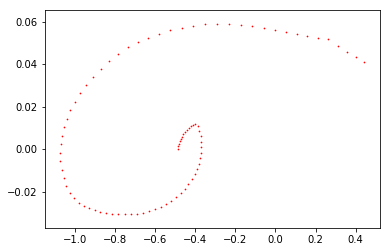

No intervention. Agent is clear.
[-0.48535774  0.        ]
Reached at step 87!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.06


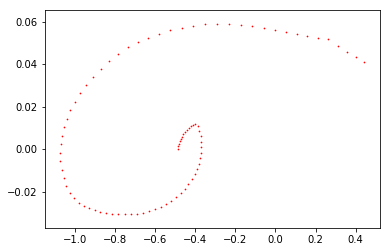

<<<<<<<<<<<<<<<<<<<<
Finished epoch 7




>>>>>>>>>>>>>>>>>>>>
Start epoch 8
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Safe]
Finished iteration 60 [Safe]
Finished iteration 70 [Safe]
Finished iteration 80 [Safe]
Finished iteration 90 [Safe]


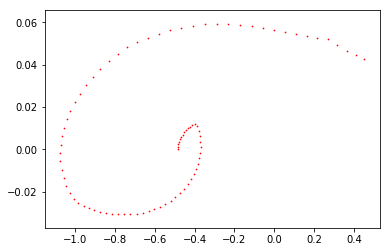

87
[Epoch 1] avg_loss: 0.002
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 87!!!!!!


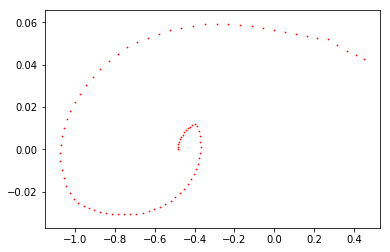

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99865298]
[-0.48414594  0.0012118 ]
>>>>>Step 1 at [-0.48414594  0.0012118 ]
NN verification via simulation
Utilize NN output [1.99956559]
[-0.48173     0.00241594]
>>>>>Step 2 at [-0.48173     0.00241594]
NN verification via simulation
Utilize NN output [1.99942904]
[-0.4781281  0.0036019]
>>>>>Step 3 at [-0.4781281  0.0036019]
NN verification via simulation
Utilize NN output [1.99935565]
[-0.47336715  0.00476096]
>>>>>Step 4 at [-0.47336715  0.00476096]
NN verification via simulation
Utilize NN output [1.99946559]
[-0.46748231  0.00588484]
>>>>>Step 5 at [-0.46748231  0.00588484]
NN verification via simulation
Utilize NN output [1.99958509]
[-0.46051697  0.00696533]
>>>>>Step 6 at [-0.46051697  0.00696533]
NN verification via simulation
Utilize NN output [1.99964944]
[-0.45252246  0.00799451]
>>>>>Step 7 at [-0.45252246  0.00799451]
NN verification via simulation
Utilize NN output [1.99966488

Utilize NN output [1.57955368]
[-0.63498785  0.05260036]
>>>>>Step 66 at [-0.63498785  0.05260036]
NN verification via simulation
Utilize NN output [1.71072694]
[-0.58050144  0.05448641]
>>>>>Step 67 at [-0.58050144  0.05448641]
NN verification via simulation
Utilize NN output [1.98802267]
[-0.5241083   0.05639314]
>>>>>Step 68 at [-0.5241083   0.05639314]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.4941485014605205e-86 [ 0.00857402 -0.00657082]
Utilize NN output [1.63687309]
[-0.46675602  0.05735227]
>>>>>Step 69 at [-0.46675602  0.05735227]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.658188315665339e-86 [ 0.04904165 -0.00786455]
Utilize NN output [1.99263143]
[-0.40833906  0.05841696]
>>>>>Step 70 at [-0.40833906  0.05841696]
NN verification via simulation
MPC feasibility verification
iteration 0 converged [3.79306098e-86] [ 0.09185932 -0.00860965]
Utilize NN output [1.99616155]
[-0.34927517  0.05906388]
>>>>>S

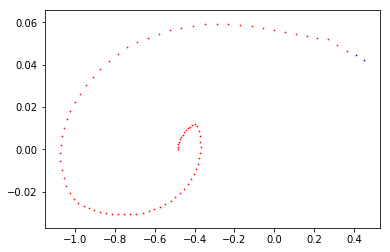

Intervention identified. Retrain agent in the pipeline.
87
[Epoch 1] avg_loss: 0.003
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 86!!!!!!


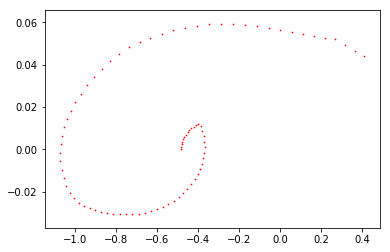

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99869364]
[-0.48414588  0.00121186]
>>>>>Step 1 at [-0.48414588  0.00121186]
NN verification via simulation
Utilize NN output [1.99956875]
[-0.48172987  0.00241601]
>>>>>Step 2 at [-0.48172987  0.00241601]
NN verification via simulation
Utilize NN output [1.99941051]
[-0.47812794  0.00360193]
>>>>>Step 3 at [-0.47812794  0.00360193]
NN verification via simulation
Utilize NN output [1.9993215]
[-0.473367    0.00476094]
>>>>>Step 4 at [-0.473367    0.00476094]
NN verification via simulation
Utilize NN output [1.99946744]
[-0.46748217  0.00588483]
>>>>>Step 5 at [-0.46748217  0.00588483]
NN verification via simulation
Utilize NN output [1.99962109]
[-0.4605168   0.00696537]
>>>>>Step 6 at [-0.4605168   0.00696537]
NN verification via simulation
Utilize NN output [1.99968966]
[-0.4525222   0.00799461]
>>>>>Step 7 at [-0.4525222   0.00799461]
NN verification via simulation
Utilize NN output [1.99969

MPC feasibility verification
iteration 0 failed 3.274433211043624e-86 [-0.02185023 -0.00448869]
Utilize NN output [1.98913068]
[-0.52284222  0.05640818]
>>>>>Step 68 at [-0.52284222  0.05640818]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.5010112935707485e-86 [ 0.00897405 -0.00662896]
Utilize NN output [1.63231187]
[-0.46549125  0.05735097]
>>>>>Step 69 at [-0.46549125  0.05735097]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.6647502660275154e-86 [ 0.04947166 -0.00791342]
Utilize NN output [1.99383417]
[-0.40708313  0.05840812]
>>>>>Step 70 at [-0.40708313  0.05840812]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.7988597490900396e-86 [ 0.09235478 -0.00864674]
Utilize NN output [1.99807994]
[-0.34803407  0.05904906]
>>>>>Step 71 at [-0.34803407  0.05904906]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.889868503459932e-86 [ 0.13831533 -0.0087582

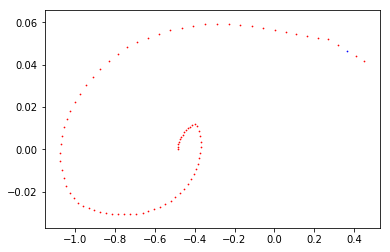

Intervention identified. Retrain agent in the pipeline.
87
[Epoch 1] avg_loss: 0.001
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.001
Finished Training
Reached at step 87!!!!!!


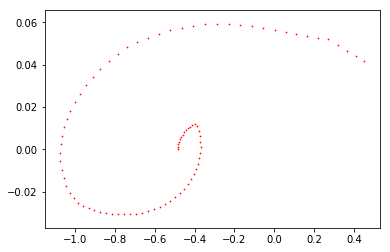

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99863786]
[-0.48414596  0.00121178]
>>>>>Step 1 at [-0.48414596  0.00121178]
NN verification via simulation
Utilize NN output [1.99956644]
[-0.48173004  0.00241592]
>>>>>Step 2 at [-0.48173004  0.00241592]
NN verification via simulation
Utilize NN output [1.99941384]
[-0.47812819  0.00360185]
>>>>>Step 3 at [-0.47812819  0.00360185]
NN verification via simulation
Utilize NN output [1.99935951]
[-0.47336727  0.00476092]
>>>>>Step 4 at [-0.47336727  0.00476092]
NN verification via simulation
Utilize NN output [1.99953059]
[-0.46748237  0.0058849 ]
>>>>>Step 5 at [-0.46748237  0.0058849 ]
NN verification via simulation
Utilize NN output [1.99967577]
[-0.46051684  0.00696553]
>>>>>Step 6 at [-0.46051684  0.00696553]
NN verification via simulation
Utilize NN output [1.99973404]
[-0.45252201  0.00799483]
>>>>>Step 7 at [-0.45252201  0.00799483]
NN verification via simulation
Utilize NN output [1.9997

[-0.57918297  0.05451036]
>>>>>Step 67 at [-0.57918297  0.05451036]
NN verification via simulation
Utilize NN output [1.98930582]
[-0.5227737   0.05640927]
>>>>>Step 68 at [-0.5227737   0.05640927]
NN verification via simulation
Utilize NN output [1.63211566]
[-0.46542245  0.05735125]
>>>>>Step 69 at [-0.46542245  0.05735125]
NN verification via simulation
Utilize NN output [1.99391265]
[-0.40701444  0.05840801]
>>>>>Step 70 at [-0.40701444  0.05840801]
NN verification via simulation
Utilize NN output [1.9985348]
[-0.34796529  0.05904915]
>>>>>Step 71 at [-0.34796529  0.05904915]
NN verification via simulation
Utilize NN output [1.99853868]
[-0.28867547  0.05928982]
>>>>>Step 72 at [-0.28867547  0.05928982]
NN verification via simulation
Utilize NN output [1.99854515]
[-0.22950749  0.05916799]
>>>>>Step 73 at [-0.22950749  0.05916799]
NN verification via simulation
Utilize NN output [1.99841356]
[-0.17077234  0.05873514]
>>>>>Step 74 at [-0.17077234  0.05873514]
NN verification via sim

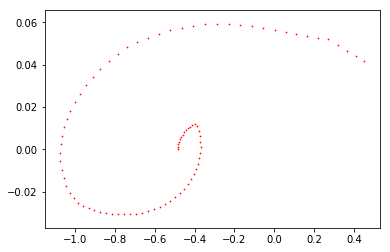

No intervention. Agent is clear.
[-0.48535774  0.        ]
Reached at step 87!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.06


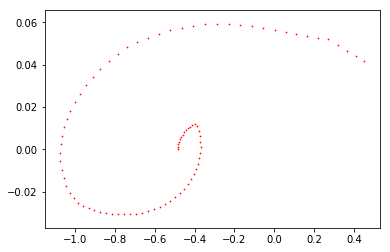

<<<<<<<<<<<<<<<<<<<<
Finished epoch 8




>>>>>>>>>>>>>>>>>>>>
Start epoch 9
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Safe]
Finished iteration 80 [Safe]
Finished iteration 90 [Safe]


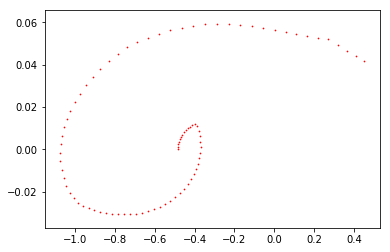

87
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.001
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 87!!!!!!


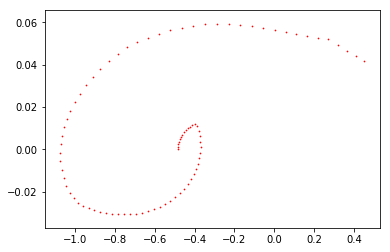

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99859538]
[-0.48414603  0.00121171]
>>>>>Step 1 at [-0.48414603  0.00121171]
NN verification via simulation
Utilize NN output [1.99958233]
[-0.48173015  0.00241588]
>>>>>Step 2 at [-0.48173015  0.00241588]
NN verification via simulation
Utilize NN output [1.99943631]
[-0.4781283   0.00360185]
>>>>>Step 3 at [-0.4781283   0.00360185]
NN verification via simulation
Utilize NN output [1.99939727]
[-0.47336733  0.00476097]
>>>>>Step 4 at [-0.47336733  0.00476097]
NN verification via simulation
Utilize NN output [1.99958828]
[-0.46748229  0.00588504]
>>>>>Step 5 at [-0.46748229  0.00588504]
NN verification via simulation
Utilize NN output [1.99973381]
[-0.46051653  0.00696575]
>>>>>Step 6 at [-0.46051653  0.00696575]
NN verification via simulation
Utilize NN output [1.99978936]
[-0.45252139  0.00799514]
>>>>>Step 7 at [-0.45252139  0.00799514]
NN verification via simulation
Utilize NN output [1.9997

Utilize NN output [1.54921922]
[-0.68634404  0.05058314]
>>>>>Step 65 at [-0.68634404  0.05058314]
NN verification via simulation
Utilize NN output [1.58493457]
[-0.63371083  0.05263321]
>>>>>Step 66 at [-0.63371083  0.05263321]
NN verification via simulation
Utilize NN output [1.71872165]
[-0.57918863  0.0545222 ]
>>>>>Step 67 at [-0.57918863  0.0545222 ]
NN verification via simulation
Utilize NN output [1.98966093]
[-0.52276695  0.05642168]
>>>>>Step 68 at [-0.52276695  0.05642168]
NN verification via simulation
Utilize NN output [1.63483971]
[-0.46539924  0.0573677 ]
>>>>>Step 69 at [-0.46539924  0.0573677 ]
NN verification via simulation
Utilize NN output [1.9937483]
[-0.4069752   0.05842404]
>>>>>Step 70 at [-0.4069752   0.05842404]
NN verification via simulation
Utilize NN output [1.99842989]
[-0.34791045  0.05906475]
>>>>>Step 71 at [-0.34791045  0.05906475]
NN verification via simulation
Utilize NN output [1.99822005]
[-0.28860587  0.05930458]
>>>>>Step 72 at [-0.28860587  0.05

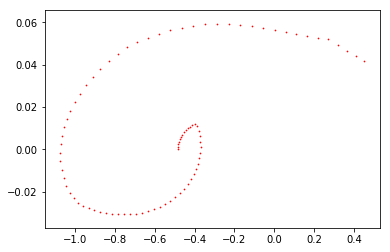

No intervention. Agent is clear.
[-0.48535774  0.        ]
Reached at step 87!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.06


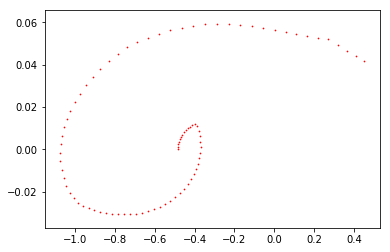

<<<<<<<<<<<<<<<<<<<<
Finished epoch 9




>>>>>>>>>>>>>>>>>>>>
Start epoch 10
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Safe]
Finished iteration 90 [Safe]


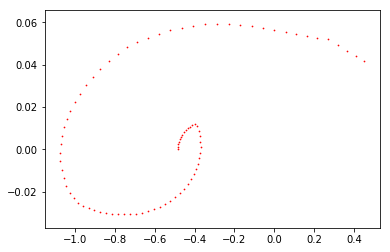

87
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 86!!!!!!


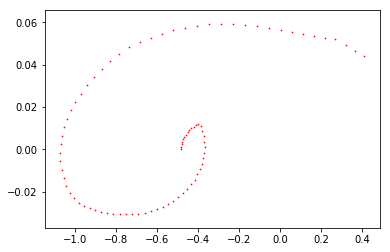

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99858475]
[-0.48414604  0.0012117 ]
>>>>>Step 1 at [-0.48414604  0.0012117 ]
NN verification via simulation
Utilize NN output [1.99959519]
[-0.48173016  0.00241589]
>>>>>Step 2 at [-0.48173016  0.00241589]
NN verification via simulation
Utilize NN output [1.99945795]
[-0.47812827  0.00360188]
>>>>>Step 3 at [-0.47812827  0.00360188]
NN verification via simulation
Utilize NN output [1.99944121]
[-0.4733672   0.00476107]
>>>>>Step 4 at [-0.4733672   0.00476107]
NN verification via simulation
Utilize NN output [1.99964016]
[-0.46748198  0.00588522]
>>>>>Step 5 at [-0.46748198  0.00588522]
NN verification via simulation
Utilize NN output [1.99977571]
[-0.46051599  0.00696599]
>>>>>Step 6 at [-0.46051599  0.00696599]
NN verification via simulation
Utilize NN output [1.99982492]
[-0.45252056  0.00799543]
>>>>>Step 7 at [-0.45252056  0.00799543]
NN verification via simulation
Utilize NN output [1.9998

[-0.68553965  0.05060194]
>>>>>Step 65 at [-0.68553965  0.05060194]
NN verification via simulation
Utilize NN output [1.5857921]
[-0.63289168  0.05264797]
>>>>>Step 66 at [-0.63289168  0.05264797]
NN verification via simulation
Utilize NN output [1.72175927]
[-0.57835599  0.05453569]
>>>>>Step 67 at [-0.57835599  0.05453569]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.2777901978331786e-86 [-0.02131777 -0.00452378]
Utilize NN output [1.98972219]
[-0.52192687  0.05642911]
>>>>>Step 68 at [-0.52192687  0.05642911]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.504300856634326e-86 [ 0.00953413 -0.00665757]
Utilize NN output [1.63331442]
[-0.46456033  0.05736654]
>>>>>Step 69 at [-0.46456033  0.05736654]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.667646175743581e-86 [ 0.05007114 -0.00793357]
Utilize NN output [1.99445015]
[-0.40614259  0.05841774]
>>>>>Step 70 at [-0.40614259  0.0584

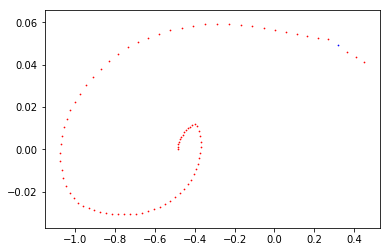

Intervention identified. Retrain agent in the pipeline.
87
[Epoch 1] avg_loss: 0.001
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 87!!!!!!


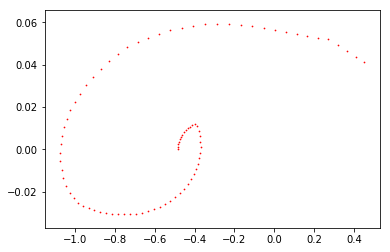

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99864997]
[-0.48414595  0.0012118 ]
>>>>>Step 1 at [-0.48414595  0.0012118 ]
NN verification via simulation
Utilize NN output [1.99965682]
[-0.48172987  0.00241608]
>>>>>Step 2 at [-0.48172987  0.00241608]
NN verification via simulation
Utilize NN output [1.99950931]
[-0.47812772  0.00360215]
>>>>>Step 3 at [-0.47812772  0.00360215]
NN verification via simulation
Utilize NN output [1.99941558]
[-0.47336643  0.00476129]
>>>>>Step 4 at [-0.47336643  0.00476129]
NN verification via simulation
Utilize NN output [1.99961637]
[-0.46748103  0.0058854 ]
>>>>>Step 5 at [-0.46748103  0.0058854 ]
NN verification via simulation
Utilize NN output [1.99977107]
[-0.46051487  0.00696616]
>>>>>Step 6 at [-0.46051487  0.00696616]
NN verification via simulation
Utilize NN output [1.9998288]
[-0.45251927  0.00799559]
>>>>>Step 7 at [-0.45251927  0.00799559]
NN verification via simulation
Utilize NN output [1.99982

Utilize NN output [1.99823399]
[-0.22858558  0.05918003]
>>>>>Step 73 at [-0.22858558  0.05918003]
NN verification via simulation
Utilize NN output [1.99803716]
[-0.16984335  0.05874223]
>>>>>Step 74 at [-0.16984335  0.05874223]
NN verification via simulation
Utilize NN output [1.99749948]
[-0.1117873   0.05805605]
>>>>>Step 75 at [-0.1117873   0.05805605]
NN verification via simulation
Utilize NN output [1.99703576]
[-0.05459643  0.05719087]
>>>>>Step 76 at [-0.05459643  0.05719087]
NN verification via simulation
Utilize NN output [1.99721845]
[0.00162373 0.05622016]
>>>>>Step 77 at [0.00162373 0.05622016]
NN verification via simulation
Utilize NN output [1.99790166]
[0.05684077 0.05521704]
>>>>>Step 78 at [0.05684077 0.05521704]
NN verification via simulation
Utilize NN output [1.99819046]
[0.11109135 0.05425059]
>>>>>Step 79 at [0.11109135 0.05425059]
NN verification via simulation
Utilize NN output [1.99826922]
[0.1644769  0.05338555]
>>>>>Step 80 at [0.1644769  0.05338555]
NN veri

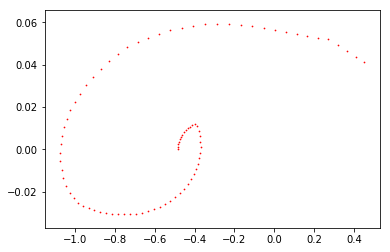

No intervention. Agent is clear.
[-0.48535774  0.        ]
Reached at step 87!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.06


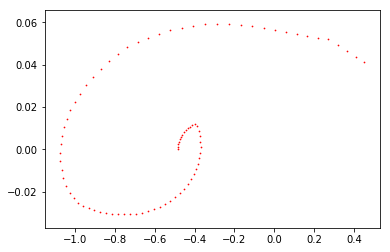

<<<<<<<<<<<<<<<<<<<<
Finished epoch 10




>>>>>>>>>>>>>>>>>>>>
Start epoch 11
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Safe]
Finished iteration 80 [Safe]
Finished iteration 90 [Safe]


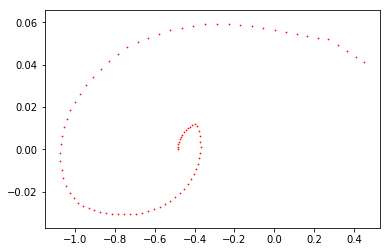

87
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 86!!!!!!


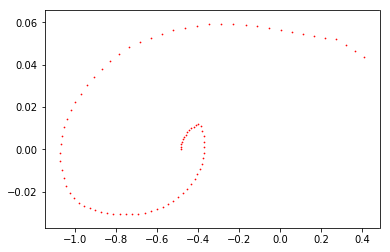

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99862311]
[-0.48414599  0.00121176]
>>>>>Step 1 at [-0.48414599  0.00121176]
NN verification via simulation
Utilize NN output [1.99965642]
[-0.48172995  0.00241603]
>>>>>Step 2 at [-0.48172995  0.00241603]
NN verification via simulation
Utilize NN output [1.9995046]
[-0.47812785  0.0036021 ]
>>>>>Step 3 at [-0.47812785  0.0036021 ]
NN verification via simulation
Utilize NN output [1.99941693]
[-0.4733666   0.00476125]
>>>>>Step 4 at [-0.4733666   0.00476125]
NN verification via simulation
Utilize NN output [1.99963926]
[-0.46748121  0.00588539]
>>>>>Step 5 at [-0.46748121  0.00588539]
NN verification via simulation
Utilize NN output [1.99979392]
[-0.46051502  0.00696619]
>>>>>Step 6 at [-0.46051502  0.00696619]
NN verification via simulation
Utilize NN output [1.9998494]
[-0.45251937  0.00799565]
>>>>>Step 7 at [-0.45251937  0.00799565]
NN verification via simulation
Utilize NN output [1.999845

Utilize NN output [1.59805306]
[-0.63277954  0.05268964]
>>>>>Step 66 at [-0.63277954  0.05268964]
NN verification via simulation
Utilize NN output [1.72376813]
[-0.57819995  0.05457959]
>>>>>Step 67 at [-0.57819995  0.05457959]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.2751701840254574e-86 [-0.02063697 -0.00450427]
Utilize NN output [1.98915577]
[-0.52172896  0.056471  ]
>>>>>Step 68 at [-0.52172896  0.056471  ]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.5006519161904244e-86 [ 0.01035944 -0.00662897]
Utilize NN output [1.63740889]
[-0.46431587  0.05741309]
>>>>>Step 69 at [-0.46431587  0.05741309]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.66339453140998e-86 [ 0.05096073 -0.00789804]
Utilize NN output [1.99430917]
[-0.4058536   0.05846227]
>>>>>Step 70 at [-0.4058536   0.05846227]
NN verification via simulation
MPC feasibility verification
iteration 0 converged [3.7960777

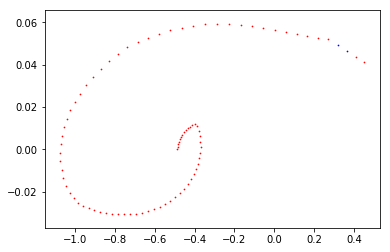

Intervention identified. Retrain agent in the pipeline.
87
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 86!!!!!!


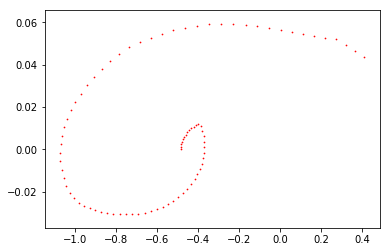

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99859887]
[-0.48414602  0.00121172]
>>>>>Step 1 at [-0.48414602  0.00121172]
NN verification via simulation
Utilize NN output [1.99966628]
[-0.48173001  0.00241601]
>>>>>Step 2 at [-0.48173001  0.00241601]
NN verification via simulation
Utilize NN output [1.99951954]
[-0.47812791  0.0036021 ]
>>>>>Step 3 at [-0.47812791  0.0036021 ]
NN verification via simulation
Utilize NN output [1.99941877]
[-0.47336665  0.00476126]
>>>>>Step 4 at [-0.47336665  0.00476126]
NN verification via simulation
Utilize NN output [1.99965264]
[-0.46748123  0.00588542]
>>>>>Step 5 at [-0.46748123  0.00588542]
NN verification via simulation
Utilize NN output [1.99981054]
[-0.460515    0.00696624]
>>>>>Step 6 at [-0.460515    0.00696624]
NN verification via simulation
Utilize NN output [1.99986611]
[-0.45251927  0.00799573]
>>>>>Step 7 at [-0.45251927  0.00799573]
NN verification via simulation
Utilize NN output [1.9998

NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.275539186774556e-86 [-0.02061253 -0.00450788]
Utilize NN output [1.98922256]
[-0.52165664  0.05647148]
>>>>>Step 68 at [-0.52165664  0.05647148]
NN verification via simulation
MPC feasibility verification
iteration 0 converged [3.50107743e-86] [ 0.0103768  -0.00663254]
Utilize NN output [1.63716444]
[-0.46424398  0.05741266]
>>>>>Step 69 at [-0.46424398  0.05741266]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.663813103831402e-86 [ 0.05097841 -0.00790118]
Utilize NN output [1.99434184]
[-0.40578261  0.05846136]
>>>>>Step 70 at [-0.40578261  0.05846136]
NN verification via simulation
MPC feasibility verification
iteration 0 converged [3.79645646e-86] [ 0.09399808 -0.00861529]
Utilize NN output [1.99877569]
[-0.34668843  0.05909419]
>>>>>Step 71 at [-0.34668843  0.05909419]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.8857456614287024e-8

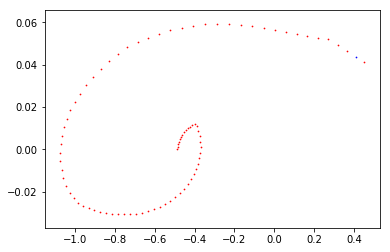

Intervention identified. Retrain agent in the pipeline.
87
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 86!!!!!!


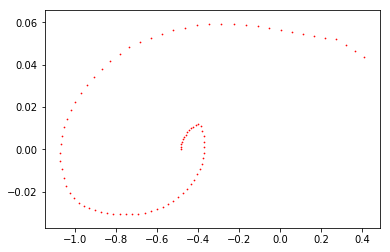

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99858875]
[-0.48414604  0.0012117 ]
>>>>>Step 1 at [-0.48414604  0.0012117 ]
NN verification via simulation
Utilize NN output [1.99966849]
[-0.48173004  0.002416  ]
>>>>>Step 2 at [-0.48173004  0.002416  ]
NN verification via simulation
Utilize NN output [1.99952239]
[-0.47812794  0.00360209]
>>>>>Step 3 at [-0.47812794  0.00360209]
NN verification via simulation
Utilize NN output [1.9994171]
[-0.4733667   0.00476125]
>>>>>Step 4 at [-0.4733667   0.00476125]
NN verification via simulation
Utilize NN output [1.99966601]
[-0.46748127  0.00588543]
>>>>>Step 5 at [-0.46748127  0.00588543]
NN verification via simulation
Utilize NN output [1.99982601]
[-0.460515    0.00696627]
>>>>>Step 6 at [-0.460515    0.00696627]
NN verification via simulation
Utilize NN output [1.99988058]
[-0.45251921  0.00799578]
>>>>>Step 7 at [-0.45251921  0.00799578]
NN verification via simulation
Utilize NN output [1.99988

MPC feasibility verification
iteration 0 failed 3.279036244060417e-86 [-0.02028633 -0.00454269]
Utilize NN output [1.98962528]
[-0.52089265  0.05648102]
>>>>>Step 68 at [-0.52089265  0.05648102]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.5046122176689735e-86 [ 0.01071551 -0.00666262]
Utilize NN output [1.63793044]
[-0.46347503  0.05741762]
>>>>>Step 69 at [-0.46347503  0.05741762]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.667085958104622e-86 [ 0.05134345 -0.00792492]
Utilize NN output [1.99503609]
[-0.40501335  0.05846168]
>>>>>Step 70 at [-0.40501335  0.05846168]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.79938950660707e-86 [ 0.09438328 -0.00863276]
Utilize NN output [1.9988666]
[-0.34592411  0.05908924]
>>>>>Step 71 at [-0.34592411  0.05908924]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.8881855046004746e-86 [ 0.14052053 -0.00871605]


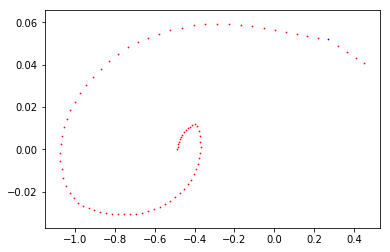

Intervention identified. Retrain agent in the pipeline.
87
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 87!!!!!!


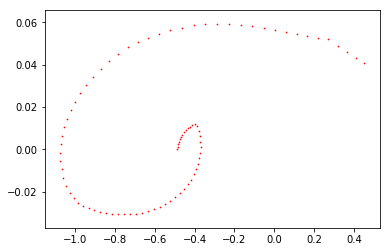

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99860969]
[-0.48414601  0.00121174]
>>>>>Step 1 at [-0.48414601  0.00121174]
NN verification via simulation
Utilize NN output [1.99968755]
[-0.48172994  0.00241606]
>>>>>Step 2 at [-0.48172994  0.00241606]
NN verification via simulation
Utilize NN output [1.99957221]
[-0.47812772  0.00360223]
>>>>>Step 3 at [-0.47812772  0.00360223]
NN verification via simulation
Utilize NN output [1.99950325]
[-0.47336621  0.00476151]
>>>>>Step 4 at [-0.47336621  0.00476151]
NN verification via simulation
Utilize NN output [1.99972272]
[-0.46748044  0.00588577]
>>>>>Step 5 at [-0.46748044  0.00588577]
NN verification via simulation
Utilize NN output [1.99985503]
[-0.46051379  0.00696665]
>>>>>Step 6 at [-0.46051379  0.00696665]
NN verification via simulation
Utilize NN output [1.99989994]
[-0.4525176   0.00799618]
>>>>>Step 7 at [-0.4525176   0.00799618]
NN verification via simulation
Utilize NN output [1.9999

NN verification via simulation
Utilize NN output [1.98963266]
[-0.52066452  0.0564817 ]
>>>>>Step 68 at [-0.52066452  0.0564817 ]
NN verification via simulation
Utilize NN output [1.63714796]
[-0.46324911  0.05741542]
>>>>>Step 69 at [-0.46324911  0.05741542]
NN verification via simulation
Utilize NN output [1.99511212]
[-0.40479117  0.05845793]
>>>>>Step 70 at [-0.40479117  0.05845793]
NN verification via simulation
Utilize NN output [1.99890332]
[-0.3457072   0.05908398]
>>>>>Step 71 at [-0.3457072   0.05908398]
NN verification via simulation
Utilize NN output [1.9984343]
[-0.28639732  0.05930988]
>>>>>Step 72 at [-0.28639732  0.05930988]
NN verification via simulation
Utilize NN output [1.99836876]
[-0.22722251  0.05917481]
>>>>>Step 73 at [-0.22722251  0.05917481]
NN verification via simulation
Utilize NN output [1.9981683]
[-0.16849176  0.05873075]
>>>>>Step 74 at [-0.16849176  0.05873075]
NN verification via simulation
Utilize NN output [1.99762249]
[-0.11045194  0.05803982]
>>>>

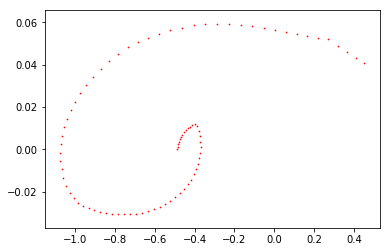

No intervention. Agent is clear.
[-0.48535774  0.        ]
Reached at step 87!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.06


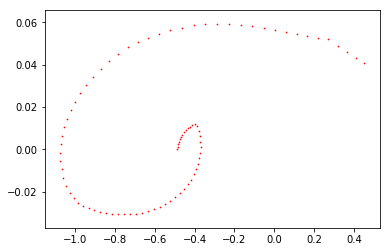

<<<<<<<<<<<<<<<<<<<<
Finished epoch 11




>>>>>>>>>>>>>>>>>>>>
Start epoch 12
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Safe]
Finished iteration 90 [Safe]


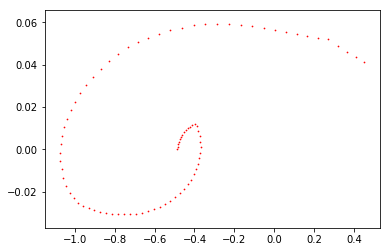

87
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 87!!!!!!


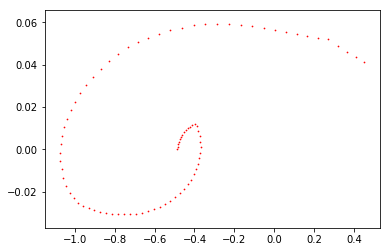

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99861724]
[-0.48414599  0.00121175]
>>>>>Step 1 at [-0.48414599  0.00121175]
NN verification via simulation
Utilize NN output [1.99968748]
[-0.48172992  0.00241607]
>>>>>Step 2 at [-0.48172992  0.00241607]
NN verification via simulation
Utilize NN output [1.99957742]
[-0.47812767  0.00360225]
>>>>>Step 3 at [-0.47812767  0.00360225]
NN verification via simulation
Utilize NN output [1.99952272]
[-0.47336612  0.00476155]
>>>>>Step 4 at [-0.47336612  0.00476155]
NN verification via simulation
Utilize NN output [1.999742]
[-0.46748027  0.00588585]
>>>>>Step 5 at [-0.46748027  0.00588585]
NN verification via simulation
Utilize NN output [1.99986673]
[-0.46051353  0.00696674]
>>>>>Step 6 at [-0.46051353  0.00696674]
NN verification via simulation
Utilize NN output [1.99990878]
[-0.45251724  0.00799629]
>>>>>Step 7 at [-0.45251724  0.00799629]
NN verification via simulation
Utilize NN output [1.999911

Utilize NN output [1.55386176]
[-0.68444194  0.05065108]
>>>>>Step 65 at [-0.68444194  0.05065108]
NN verification via simulation
Utilize NN output [1.60191159]
[-0.63172794  0.052714  ]
>>>>>Step 66 at [-0.63172794  0.052714  ]
NN verification via simulation
Utilize NN output [1.72917193]
[-0.57712336  0.05460458]
>>>>>Step 67 at [-0.57712336  0.05460458]
NN verification via simulation
Utilize NN output [1.98983819]
[-0.52063432  0.05648905]
>>>>>Step 68 at [-0.52063432  0.05648905]
NN verification via simulation
Utilize NN output [1.63861555]
[-0.46320958  0.05742474]
>>>>>Step 69 at [-0.46320958  0.05742474]
NN verification via simulation
Utilize NN output [1.99504692]
[-0.40474272  0.05846686]
>>>>>Step 70 at [-0.40474272  0.05846686]
NN verification via simulation
Utilize NN output [1.9989645]
[-0.34565006  0.05909266]
>>>>>Step 71 at [-0.34565006  0.05909266]
NN verification via simulation
Utilize NN output [1.99848879]
[-0.28633179  0.05931827]
>>>>>Step 72 at [-0.28633179  0.05

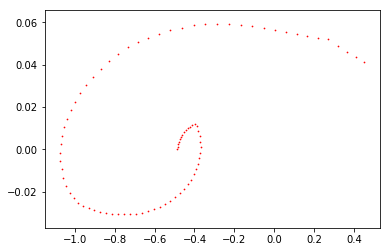

No intervention. Agent is clear.
[-0.48535774  0.        ]
Reached at step 87!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.06


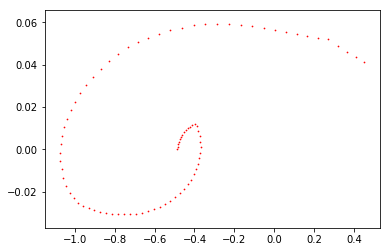

<<<<<<<<<<<<<<<<<<<<
Finished epoch 12




>>>>>>>>>>>>>>>>>>>>
Start epoch 13
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Safe]
Finished iteration 90 [Safe]


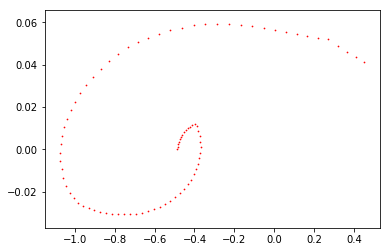

87
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 86!!!!!!


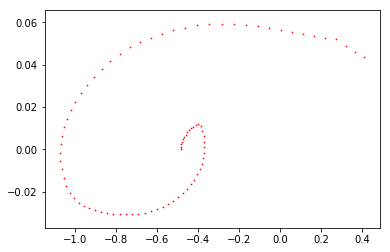

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99861463]
[-0.484146    0.00121174]
>>>>>Step 1 at [-0.484146    0.00121174]
NN verification via simulation
Utilize NN output [1.9996923]
[-0.48172992  0.00241608]
>>>>>Step 2 at [-0.48172992  0.00241608]
NN verification via simulation
Utilize NN output [1.9995938]
[-0.47812765  0.00360228]
>>>>>Step 3 at [-0.47812765  0.00360228]
NN verification via simulation
Utilize NN output [1.99955176]
[-0.47336602  0.00476163]
>>>>>Step 4 at [-0.47336602  0.00476163]
NN verification via simulation
Utilize NN output [1.99976095]
[-0.46748008  0.00588595]
>>>>>Step 5 at [-0.46748008  0.00588595]
NN verification via simulation
Utilize NN output [1.99987584]
[-0.46051322  0.00696686]
>>>>>Step 6 at [-0.46051322  0.00696686]
NN verification via simulation
Utilize NN output [1.99991485]
[-0.45251681  0.00799641]
>>>>>Step 7 at [-0.45251681  0.00799641]
NN verification via simulation
Utilize NN output [1.999919

[-0.6317061   0.05271611]
>>>>>Step 66 at [-0.6317061   0.05271611]
NN verification via simulation
Utilize NN output [1.72965408]
[-0.57709884  0.05460725]
>>>>>Step 67 at [-0.57709884  0.05460725]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.279720818829362e-86 [-0.02005957 -0.00455064]
Utilize NN output [1.98980346]
[-0.52060735  0.05649149]
>>>>>Step 68 at [-0.52060735  0.05649149]
NN verification via simulation
MPC feasibility verification
iteration 0 converged [3.50509486e-86] [ 0.01097702 -0.00666715]
Utilize NN output [1.63911212]
[-0.46317963  0.05742772]
>>>>>Step 69 at [-0.46317963  0.05742772]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.667420147486748e-86 [ 0.05161834 -0.0079265 ]
Utilize NN output [1.99496754]
[-0.40471013  0.05846951]
>>>>>Step 70 at [-0.40471013  0.05846951]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.799448703801387e-86 [ 0.09468241 -0.00863053]

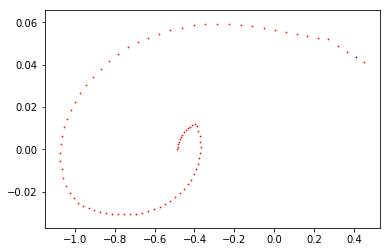

Intervention identified. Retrain agent in the pipeline.
87
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 86!!!!!!


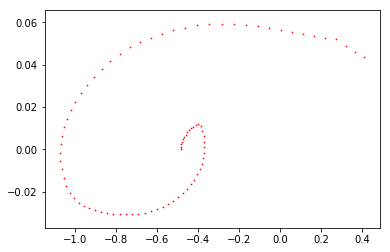

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99861194]
[-0.484146    0.00121174]
>>>>>Step 1 at [-0.484146    0.00121174]
NN verification via simulation
Utilize NN output [1.99968459]
[-0.48172994  0.00241606]
>>>>>Step 2 at [-0.48172994  0.00241606]
NN verification via simulation
Utilize NN output [1.99958123]
[-0.4781277   0.00360224]
>>>>>Step 3 at [-0.4781277   0.00360224]
NN verification via simulation
Utilize NN output [1.99955672]
[-0.4733661  0.0047616]
>>>>>Step 4 at [-0.4733661  0.0047616]
NN verification via simulation
Utilize NN output [1.99977126]
[-0.46748017  0.00588594]
>>>>>Step 5 at [-0.46748017  0.00588594]
NN verification via simulation
Utilize NN output [1.99988239]
[-0.46051331  0.00696686]
>>>>>Step 6 at [-0.46051331  0.00696686]
NN verification via simulation
Utilize NN output [1.99991991]
[-0.4525169   0.00799641]
>>>>>Step 7 at [-0.4525169   0.00799641]
NN verification via simulation
Utilize NN output [1.99992519

[-0.57708695  0.0546088 ]
>>>>>Step 67 at [-0.57708695  0.0546088 ]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.279661307619815e-86 [-0.02003344 -0.00455027]
Utilize NN output [1.98983704]
[-0.52059394  0.056493  ]
>>>>>Step 68 at [-0.52059394  0.056493  ]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.504982502549356e-86 [ 0.01101109 -0.00666629]
Utilize NN output [1.63937587]
[-0.46316441  0.05742953]
>>>>>Step 69 at [-0.46316441  0.05742953]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.6672808194088194e-86 [ 0.05165534 -0.00792531]
Utilize NN output [1.99497792]
[-0.4046932   0.05847122]
>>>>>Step 70 at [-0.4046932   0.05847122]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.7992624128024374e-86 [ 0.09472458 -0.00862883]
Utilize NN output [1.99909079]
[-0.34559634  0.05909685]
>>>>>Step 71 at [-0.34559634  0.05909685]
NN verification via simula

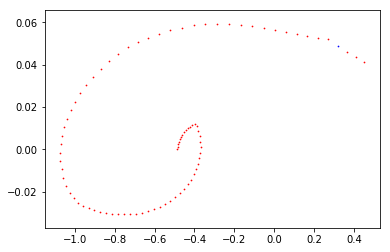

Intervention identified. Retrain agent in the pipeline.
87
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 87!!!!!!


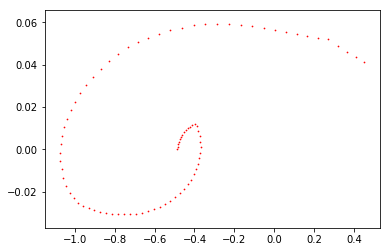

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99859565]
[-0.48414603  0.00121171]
>>>>>Step 1 at [-0.48414603  0.00121171]
NN verification via simulation
Utilize NN output [1.9996822]
[-0.48172999  0.00241603]
>>>>>Step 2 at [-0.48172999  0.00241603]
NN verification via simulation
Utilize NN output [1.99958173]
[-0.47812778  0.00360221]
>>>>>Step 3 at [-0.47812778  0.00360221]
NN verification via simulation
Utilize NN output [1.99957066]
[-0.47336619  0.00476159]
>>>>>Step 4 at [-0.47336619  0.00476159]
NN verification via simulation
Utilize NN output [1.99978329]
[-0.46748024  0.00588595]
>>>>>Step 5 at [-0.46748024  0.00588595]
NN verification via simulation
Utilize NN output [1.99988868]
[-0.46051336  0.00696688]
>>>>>Step 6 at [-0.46051336  0.00696688]
NN verification via simulation
Utilize NN output [1.99992405]
[-0.45251691  0.00799644]
>>>>>Step 7 at [-0.45251691  0.00799644]
NN verification via simulation
Utilize NN output [1.99992

Utilize NN output [1.98980853]
[-0.52058836  0.0564927 ]
>>>>>Step 68 at [-0.52058836  0.0564927 ]
NN verification via simulation
Utilize NN output [1.63938384]
[-0.46315916  0.05742919]
>>>>>Step 69 at [-0.46315916  0.05742919]
NN verification via simulation
Utilize NN output [1.99495853]
[-0.40468835  0.05847081]
>>>>>Step 70 at [-0.40468835  0.05847081]
NN verification via simulation
Utilize NN output [1.99912761]
[-0.34559188  0.05909647]
>>>>>Step 71 at [-0.34559188  0.05909647]
NN verification via simulation
Utilize NN output [1.99855489]
[-0.28627007  0.05932181]
>>>>>Step 72 at [-0.28627007  0.05932181]
NN verification via simulation
Utilize NN output [1.99847814]
[-0.22708389  0.05918618]
>>>>>Step 73 at [-0.22708389  0.05918618]
NN verification via simulation
Utilize NN output [1.99827159]
[-0.16834226  0.05874162]
>>>>>Step 74 at [-0.16834226  0.05874162]
NN verification via simulation
Utilize NN output [1.99774224]
[-0.11029193  0.05805033]
>>>>>Step 75 at [-0.11029193  0.0

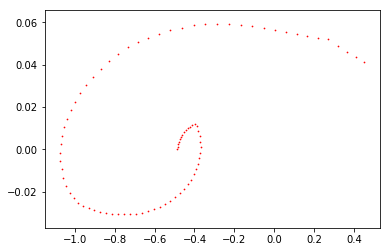

No intervention. Agent is clear.
[-0.48535774  0.        ]
Reached at step 87!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.06


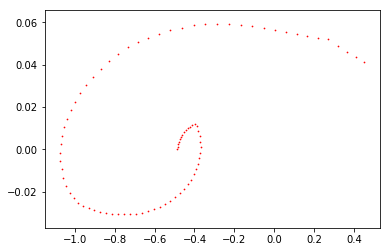

<<<<<<<<<<<<<<<<<<<<
Finished epoch 13




>>>>>>>>>>>>>>>>>>>>
Start epoch 14
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Converged.


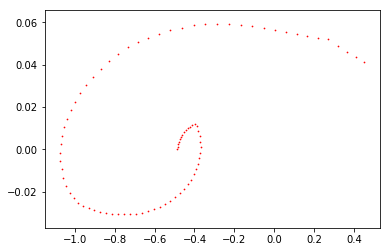

87
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 87!!!!!!


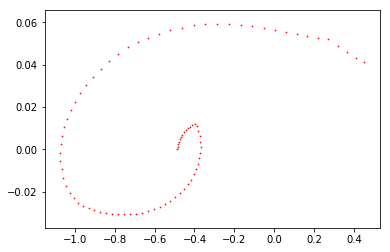

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.9985861]
[-0.48414604  0.0012117 ]
>>>>>Step 1 at [-0.48414604  0.0012117 ]
NN verification via simulation
Utilize NN output [1.99968733]
[-0.48173002  0.00241603]
>>>>>Step 2 at [-0.48173002  0.00241603]
NN verification via simulation
Utilize NN output [1.9995918]
[-0.47812779  0.00360222]
>>>>>Step 3 at [-0.47812779  0.00360222]
NN verification via simulation
Utilize NN output [1.99958396]
[-0.47336617  0.00476162]
>>>>>Step 4 at [-0.47336617  0.00476162]
NN verification via simulation
Utilize NN output [1.99979354]
[-0.46748018  0.00588599]
>>>>>Step 5 at [-0.46748018  0.00588599]
NN verification via simulation
Utilize NN output [1.99989427]
[-0.46051325  0.00696693]
>>>>>Step 6 at [-0.46051325  0.00696693]
NN verification via simulation
Utilize NN output [1.9999278]
[-0.45251674  0.0079965 ]
>>>>>Step 7 at [-0.45251674  0.0079965 ]
NN verification via simulation
Utilize NN output [1.9999341

NN verification via simulation
Utilize NN output [1.55458063]
[-0.6843634   0.05065303]
>>>>>Step 65 at [-0.6843634   0.05065303]
NN verification via simulation
Utilize NN output [1.60285492]
[-0.63164656  0.05271684]
>>>>>Step 66 at [-0.63164656  0.05271684]
NN verification via simulation
Utilize NN output [1.73012637]
[-0.57703829  0.05460828]
>>>>>Step 67 at [-0.57703829  0.05460828]
NN verification via simulation
Utilize NN output [1.98972632]
[-0.52054634  0.05649195]
>>>>>Step 68 at [-0.52054634  0.05649195]
NN verification via simulation
Utilize NN output [1.63924108]
[-0.46311842  0.05742791]
>>>>>Step 69 at [-0.46311842  0.05742791]
NN verification via simulation
Utilize NN output [1.99497144]
[-0.40464917  0.05846925]
>>>>>Step 70 at [-0.40464917  0.05846925]
NN verification via simulation
Utilize NN output [1.99915406]
[-0.34555449  0.05909468]
>>>>>Step 71 at [-0.34555449  0.05909468]
NN verification via simulation
Utilize NN output [1.99855086]
[-0.28623473  0.05931977]
>>

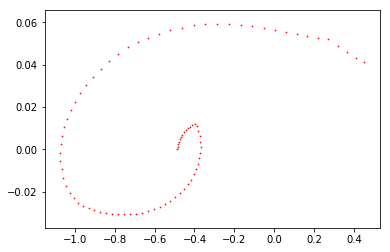

No intervention. Agent is clear.
[-0.48535774  0.        ]
Reached at step 87!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.06


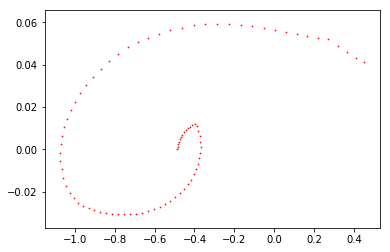

<<<<<<<<<<<<<<<<<<<<
Finished epoch 14




>>>>>>>>>>>>>>>>>>>>
Start epoch 15
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Converged.


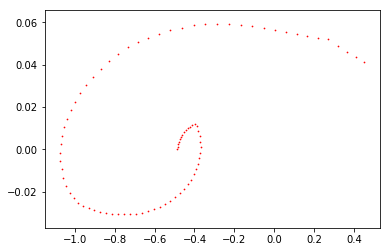

87
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 86!!!!!!


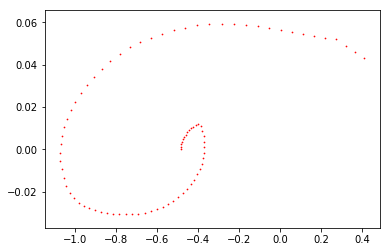

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99859581]
[-0.48414603  0.00121171]
>>>>>Step 1 at [-0.48414603  0.00121171]
NN verification via simulation
Utilize NN output [1.99970543]
[-0.48172996  0.00241607]
>>>>>Step 2 at [-0.48172996  0.00241607]
NN verification via simulation
Utilize NN output [1.9996218]
[-0.47812765  0.00360231]
>>>>>Step 3 at [-0.47812765  0.00360231]
NN verification via simulation
Utilize NN output [1.9996072]
[-0.47336591  0.00476174]
>>>>>Step 4 at [-0.47336591  0.00476174]
NN verification via simulation
Utilize NN output [1.99980408]
[-0.46747978  0.00588613]
>>>>>Step 5 at [-0.46747978  0.00588613]
NN verification via simulation
Utilize NN output [1.99989879]
[-0.46051271  0.00696707]
>>>>>Step 6 at [-0.46051271  0.00696707]
NN verification via simulation
Utilize NN output [1.99993054]
[-0.45251607  0.00799664]
>>>>>Step 7 at [-0.45251607  0.00799664]
NN verification via simulation
Utilize NN output [1.999937

Utilize NN output [1.98967416]
[-0.52037506  0.05649092]
>>>>>Step 68 at [-0.52037506  0.05649092]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.506567570425327e-86 [ 0.01101587 -0.00667946]
Utilize NN output [1.63902466]
[-0.46294978  0.05742528]
>>>>>Step 69 at [-0.46294978  0.05742528]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.668898614230206e-86 [ 0.05165446 -0.00793765]
Utilize NN output [1.99498663]
[-0.40448438  0.0584654 ]
>>>>>Step 70 at [-0.40448438  0.0584654 ]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.800861643829009e-86 [ 0.0947212  -0.00864023]
Utilize NN output [1.9991823]
[-0.34539468  0.0590897 ]
>>>>>Step 71 at [-0.34539468  0.0590897 ]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.889215873081558e-86 [ 0.1408895  -0.00871777]
Utilize NN output [1.99857082]
[-0.28608089  0.05931379]
>>>>>Step 72 at [-0.28608089  0.05931379

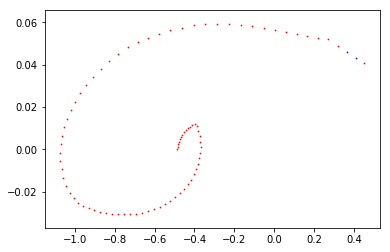

Intervention identified. Retrain agent in the pipeline.
87
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 86!!!!!!


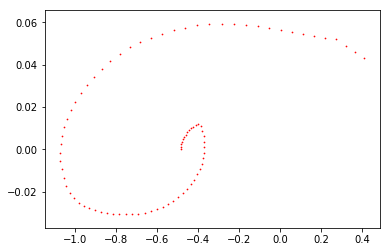

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99859696]
[-0.48414603  0.00121172]
>>>>>Step 1 at [-0.48414603  0.00121172]
NN verification via simulation
Utilize NN output [1.9996981]
[-0.48172997  0.00241606]
>>>>>Step 2 at [-0.48172997  0.00241606]
NN verification via simulation
Utilize NN output [1.9996134]
[-0.47812768  0.00360229]
>>>>>Step 3 at [-0.47812768  0.00360229]
NN verification via simulation
Utilize NN output [1.99962057]
[-0.47336594  0.00476174]
>>>>>Step 4 at [-0.47336594  0.00476174]
NN verification via simulation
Utilize NN output [1.99981422]
[-0.4674798   0.00588614]
>>>>>Step 5 at [-0.4674798   0.00588614]
NN verification via simulation
Utilize NN output [1.99990311]
[-0.46051271  0.00696709]
>>>>>Step 6 at [-0.46051271  0.00696709]
NN verification via simulation
Utilize NN output [1.99993317]
[-0.45251604  0.00799666]
>>>>>Step 7 at [-0.45251604  0.00799666]
NN verification via simulation
Utilize NN output [1.999940

NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.281283058747869e-86 [-0.02000428 -0.00456553]
Utilize NN output [1.98968181]
[-0.52034156  0.05649094]
>>>>>Step 68 at [-0.52034156  0.05649094]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.5067691088980096e-86 [ 0.01102323 -0.00668114]
Utilize NN output [1.63901199]
[-0.46291652  0.05742503]
>>>>>Step 69 at [-0.46291652  0.05742503]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.669099155774731e-86 [ 0.05166164 -0.00793916]
Utilize NN output [1.99499162]
[-0.40445161  0.05846491]
>>>>>Step 70 at [-0.40445161  0.05846491]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.8010486992462004e-86 [ 0.09472927 -0.00864149]
Utilize NN output [1.99921636]
[-0.34536257  0.05908904]
>>>>>Step 71 at [-0.34536257  0.05908904]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.8893858565256

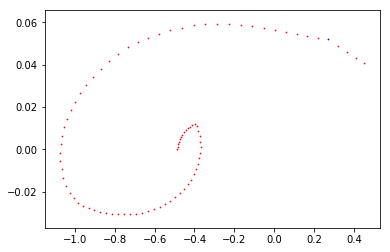

Intervention identified. Retrain agent in the pipeline.
87
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 87!!!!!!


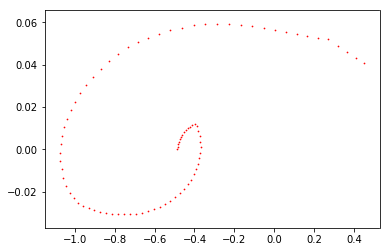

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99862227]
[-0.48414599  0.00121175]
>>>>>Step 1 at [-0.48414599  0.00121175]
NN verification via simulation
Utilize NN output [1.99968301]
[-0.48172991  0.00241607]
>>>>>Step 2 at [-0.48172991  0.00241607]
NN verification via simulation
Utilize NN output [1.99958464]
[-0.47812765  0.00360226]
>>>>>Step 3 at [-0.47812765  0.00360226]
NN verification via simulation
Utilize NN output [1.9996127]
[-0.47336595  0.0047617 ]
>>>>>Step 4 at [-0.47336595  0.0047617 ]
NN verification via simulation
Utilize NN output [1.99981906]
[-0.46747985  0.00588611]
>>>>>Step 5 at [-0.46747985  0.00588611]
NN verification via simulation
Utilize NN output [1.99990653]
[-0.46051278  0.00696706]
>>>>>Step 6 at [-0.46051278  0.00696706]
NN verification via simulation
Utilize NN output [1.99993541]
[-0.45251615  0.00799664]
>>>>>Step 7 at [-0.45251615  0.00799664]
NN verification via simulation
Utilize NN output [1.99994

Utilize NN output [1.98923378]
[-0.52021491  0.05649086]
>>>>>Step 68 at [-0.52021491  0.05649086]
NN verification via simulation
Utilize NN output [1.63898429]
[-0.46279096  0.05742395]
>>>>>Step 69 at [-0.46279096  0.05742395]
NN verification via simulation
Utilize NN output [1.99483958]
[-0.40432828  0.05846268]
>>>>>Step 70 at [-0.40432828  0.05846268]
NN verification via simulation
Utilize NN output [1.99921466]
[-0.34524234  0.05908594]
>>>>>Step 71 at [-0.34524234  0.05908594]
NN verification via simulation
Utilize NN output [1.99856809]
[-0.2859333   0.05930904]
>>>>>Step 72 at [-0.2859333   0.05930904]
NN verification via simulation
Utilize NN output [1.99844366]
[-0.22676185  0.05917145]
>>>>>Step 73 at [-0.22676185  0.05917145]
NN verification via simulation
Utilize NN output [1.9982352]
[-0.16803653  0.05872532]
>>>>>Step 74 at [-0.16803653  0.05872532]
NN verification via simulation
Utilize NN output [1.9977646]
[-0.11000358  0.05803295]
>>>>>Step 75 at [-0.11000358  0.058

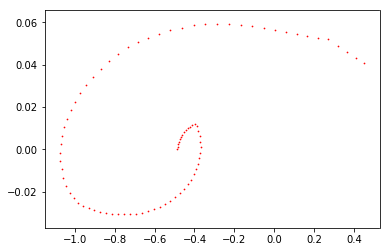

No intervention. Agent is clear.
[-0.48535774  0.        ]
Reached at step 87!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.06


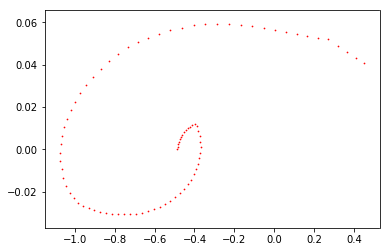

<<<<<<<<<<<<<<<<<<<<
Finished epoch 15




>>>>>>>>>>>>>>>>>>>>
Start epoch 16
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Safe]


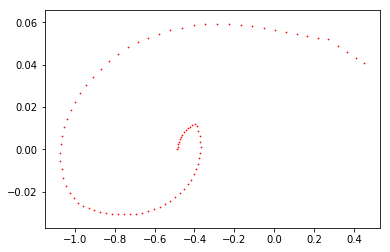

87
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 86!!!!!!


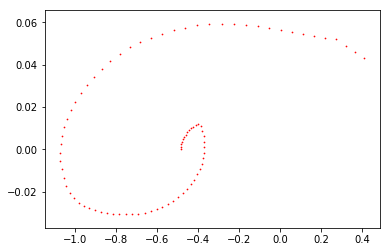

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99863308]
[-0.48414597  0.00121177]
>>>>>Step 1 at [-0.48414597  0.00121177]
NN verification via simulation
Utilize NN output [1.9996994]
[-0.48172986  0.00241611]
>>>>>Step 2 at [-0.48172986  0.00241611]
NN verification via simulation
Utilize NN output [1.99961525]
[-0.47812751  0.00360235]
>>>>>Step 3 at [-0.47812751  0.00360235]
NN verification via simulation
Utilize NN output [1.99964064]
[-0.47336568  0.00476183]
>>>>>Step 4 at [-0.47336568  0.00476183]
NN verification via simulation
Utilize NN output [1.99982969]
[-0.46747943  0.00588625]
>>>>>Step 5 at [-0.46747943  0.00588625]
NN verification via simulation
Utilize NN output [1.99991039]
[-0.46051223  0.00696721]
>>>>>Step 6 at [-0.46051223  0.00696721]
NN verification via simulation
Utilize NN output [1.99993756]
[-0.45251545  0.00799678]
>>>>>Step 7 at [-0.45251545  0.00799678]
NN verification via simulation
Utilize NN output [1.99994

[-0.68398897  0.05065911]
>>>>>Step 65 at [-0.68398897  0.05065911]
NN verification via simulation
Utilize NN output [1.60320874]
[-0.631268    0.05272097]
>>>>>Step 66 at [-0.631268    0.05272097]
NN verification via simulation
Utilize NN output [1.73171273]
[-0.57665591  0.05461209]
>>>>>Step 67 at [-0.57665591  0.05461209]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.2821999944324155e-86 [-0.01994583 -0.00457444]
Utilize NN output [1.98910326]
[-0.52016392  0.05649199]
>>>>>Step 68 at [-0.52016392  0.05649199]
NN verification via simulation
MPC feasibility verification
iteration 0 failed 3.50771591395968e-86 [ 0.01108189 -0.00668911]
Utilize NN output [1.6391334]
[-0.46273899  0.05742493]
>>>>>Step 69 at [-0.46273899  0.05742493]
NN verification via simulation
MPC feasibility verification
iteration 0 converged [3.67005292e-86] [ 0.05171702 -0.00794624]
Utilize NN output [1.99486143]
[-0.40427568  0.05846331]
>>>>>Step 70 at [-0.40427568  0.0584633

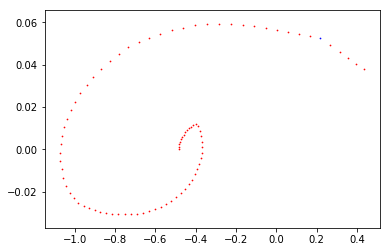

Intervention identified. Retrain agent in the pipeline.
87
[Epoch 1] avg_loss: 0.042
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 87!!!!!!


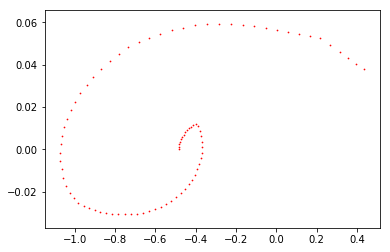

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99863811]
[-0.48414596  0.00121178]
>>>>>Step 1 at [-0.48414596  0.00121178]
NN verification via simulation
Utilize NN output [1.99968275]
[-0.48172987  0.0024161 ]
>>>>>Step 2 at [-0.48172987  0.0024161 ]
NN verification via simulation
Utilize NN output [1.99962874]
[-0.47812752  0.00360235]
>>>>>Step 3 at [-0.47812752  0.00360235]
NN verification via simulation
Utilize NN output [1.99970011]
[-0.4733656   0.00476192]
>>>>>Step 4 at [-0.4733656   0.00476192]
NN verification via simulation
Utilize NN output [1.99984553]
[-0.46747923  0.00588636]
>>>>>Step 5 at [-0.46747923  0.00588636]
NN verification via simulation
Utilize NN output [1.99991628]
[-0.46051191  0.00696733]
>>>>>Step 6 at [-0.46051191  0.00696733]
NN verification via simulation
Utilize NN output [1.99994206]
[-0.452515    0.00799691]
>>>>>Step 7 at [-0.452515    0.00799691]
NN verification via simulation
Utilize NN output [1.9999

Utilize NN output [1.98909366]
[-0.52008928  0.05649259]
>>>>>Step 68 at [-0.52008928  0.05649259]
NN verification via simulation
Utilize NN output [1.63902693]
[-0.46266447  0.0574248 ]
>>>>>Step 69 at [-0.46266447  0.0574248 ]
NN verification via simulation
Utilize NN output [1.99487214]
[-0.40420183  0.05846265]
>>>>>Step 70 at [-0.40420183  0.05846265]
NN verification via simulation
Utilize NN output [1.99959939]
[-0.34511623  0.05908559]
>>>>>Step 71 at [-0.34511623  0.05908559]
NN verification via simulation
Utilize NN output [1.99938707]
[-0.28580712  0.05930911]
>>>>>Step 72 at [-0.28580712  0.05930911]
NN verification via simulation
Utilize NN output [1.99925898]
[-0.2266351   0.05917202]
>>>>>Step 73 at [-0.2266351   0.05917202]
NN verification via simulation
Utilize NN output [1.99904763]
[-0.16790858  0.05872652]
>>>>>Step 74 at [-0.16790858  0.05872652]
NN verification via simulation
Utilize NN output [1.99879464]
[-0.10987335  0.05803523]
>>>>>Step 75 at [-0.10987335  0.0

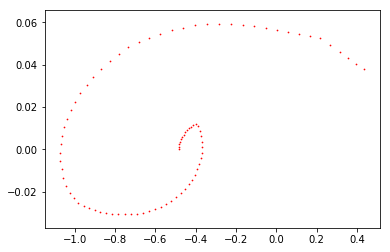

No intervention. Agent is clear.
[-0.48535774  0.        ]
Reached at step 87!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.06


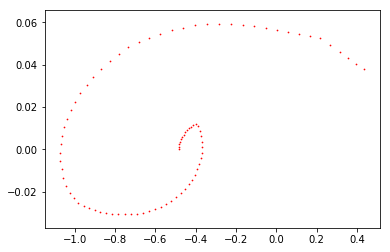

<<<<<<<<<<<<<<<<<<<<
Finished epoch 16




>>>>>>>>>>>>>>>>>>>>
Start epoch 17
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Safe]
Finished iteration 60 [Safe]
Finished iteration 70 [Safe]
Finished iteration 80 [Safe]
Finished iteration 90 [Safe]


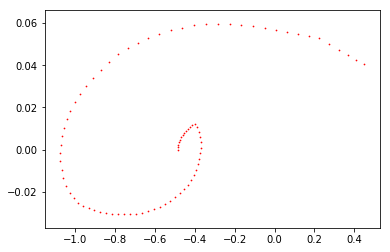

87
[Epoch 1] avg_loss: 0.005
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 87!!!!!!


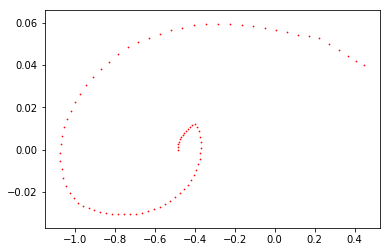

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99879618]
[-0.48414573  0.00121202]
>>>>>Step 1 at [-0.48414573  0.00121202]
NN verification via simulation
Utilize NN output [1.99975706]
[-0.48172928  0.00241644]
>>>>>Step 2 at [-0.48172928  0.00241644]
NN verification via simulation
Utilize NN output [1.9997293]
[-0.47812644  0.00360284]
>>>>>Step 3 at [-0.47812644  0.00360284]
NN verification via simulation
Utilize NN output [1.9997698]
[-0.47336393  0.00476251]
>>>>>Step 4 at [-0.47336393  0.00476251]
NN verification via simulation
Utilize NN output [1.99987621]
[-0.46747694  0.00588699]
>>>>>Step 5 at [-0.46747694  0.00588699]
NN verification via simulation
Utilize NN output [1.99993095]
[-0.46050899  0.00696796]
>>>>>Step 6 at [-0.46050899  0.00696796]
NN verification via simulation
Utilize NN output [1.99995065]
[-0.45251146  0.00799753]
>>>>>Step 7 at [-0.45251146  0.00799753]
NN verification via simulation
Utilize NN output [1.999954

NN verification via simulation
Utilize NN output [1.98054714]
[-0.73415793  0.04837597]
>>>>>Step 64 at [-0.73415793  0.04837597]
NN verification via simulation
Utilize NN output [1.60165602]
[-0.68340323  0.0507547 ]
>>>>>Step 65 at [-0.68340323  0.0507547 ]
NN verification via simulation
Utilize NN output [1.6622238]
[-0.63050204  0.05290119]
>>>>>Step 66 at [-0.63050204  0.05290119]
NN verification via simulation
Utilize NN output [1.77972297]
[-0.57564317  0.05485887]
>>>>>Step 67 at [-0.57564317  0.05485887]
NN verification via simulation
Utilize NN output [1.99134197]
[-0.51890854  0.05673463]
>>>>>Step 68 at [-0.51890854  0.05673463]
NN verification via simulation
Utilize NN output [1.70099311]
[-0.46115759  0.05775095]
>>>>>Step 69 at [-0.46115759  0.05775095]
NN verification via simulation
Utilize NN output [1.99647828]
[-0.4023775   0.05878009]
>>>>>Step 70 at [-0.4023775   0.05878009]
NN verification via simulation
Utilize NN output [1.9988116]
[-0.34298844  0.05938906]
>>>>

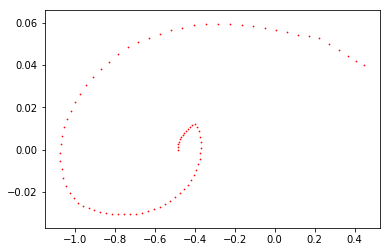

No intervention. Agent is clear.
[-0.48535774  0.        ]
Reached at step 87!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.06


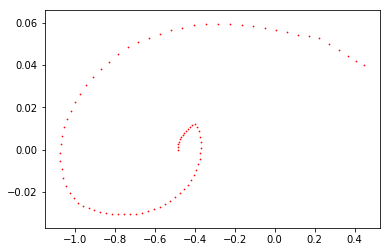

<<<<<<<<<<<<<<<<<<<<
Finished epoch 17




>>>>>>>>>>>>>>>>>>>>
Start epoch 18
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Safe]
Finished iteration 70 [Safe]
Finished iteration 80 [Safe]
Finished iteration 90 [Safe]


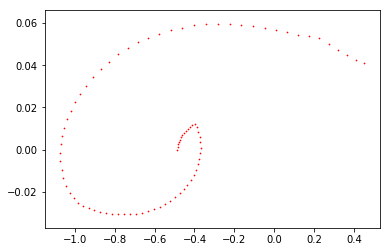

87
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 87!!!!!!


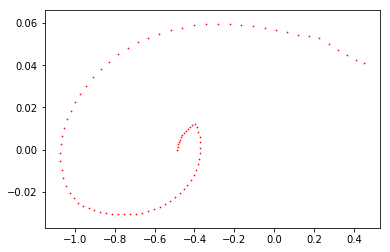

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99880842]
[-0.48414571  0.00121203]
>>>>>Step 1 at [-0.48414571  0.00121203]
NN verification via simulation
Utilize NN output [1.9997735]
[-0.48172922  0.00241649]
>>>>>Step 2 at [-0.48172922  0.00241649]
NN verification via simulation
Utilize NN output [1.99973992]
[-0.47812632  0.0036029 ]
>>>>>Step 3 at [-0.47812632  0.0036029 ]
NN verification via simulation
Utilize NN output [1.99977354]
[-0.47336375  0.00476257]
>>>>>Step 4 at [-0.47336375  0.00476257]
NN verification via simulation
Utilize NN output [1.99988281]
[-0.46747669  0.00588706]
>>>>>Step 5 at [-0.46747669  0.00588706]
NN verification via simulation
Utilize NN output [1.99993543]
[-0.46050866  0.00696803]
>>>>>Step 6 at [-0.46050866  0.00696803]
NN verification via simulation
Utilize NN output [1.99995324]
[-0.45251105  0.00799761]
>>>>>Step 7 at [-0.45251105  0.00799761]
NN verification via simulation
Utilize NN output [1.99995

[-0.73425474  0.04837392]
>>>>>Step 64 at [-0.73425474  0.04837392]
NN verification via simulation
Utilize NN output [1.61770294]
[-0.68347744  0.05077731]
>>>>>Step 65 at [-0.68347744  0.05077731]
NN verification via simulation
Utilize NN output [1.67654873]
[-0.63053167  0.05294577]
>>>>>Step 66 at [-0.63053167  0.05294577]
NN verification via simulation
Utilize NN output [1.78916234]
[-0.57561384  0.05491782]
>>>>>Step 67 at [-0.57561384  0.05491782]
NN verification via simulation
Utilize NN output [1.99163427]
[-0.51882003  0.05679381]
>>>>>Step 68 at [-0.51882003  0.05679381]
NN verification via simulation
Utilize NN output [1.71319429]
[-0.46099227  0.05782776]
>>>>>Step 69 at [-0.46099227  0.05782776]
NN verification via simulation
Utilize NN output [1.99664934]
[-0.40213633  0.05885594]
>>>>>Step 70 at [-0.40213633  0.05885594]
NN verification via simulation
Utilize NN output [1.99875605]
[-0.3426732   0.05946313]
>>>>>Step 71 at [-0.3426732   0.05946313]
NN verification via si

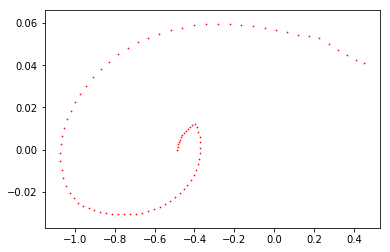

No intervention. Agent is clear.
[-0.48535774  0.        ]
Reached at step 87!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.06


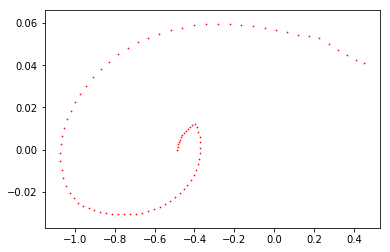

<<<<<<<<<<<<<<<<<<<<
Finished epoch 18




>>>>>>>>>>>>>>>>>>>>
Start epoch 19
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Safe]


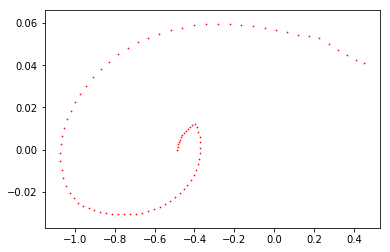

87
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
[Epoch 101] avg_loss: 0.000
[Epoch 151] avg_loss: 0.000
[Epoch 201] avg_loss: 0.000
[Epoch 251] avg_loss: 0.000
[Epoch 301] avg_loss: 0.000
[Epoch 351] avg_loss: 0.000
[Epoch 401] avg_loss: 0.000
[Epoch 451] avg_loss: 0.000
[Epoch 501] avg_loss: 0.000
[Epoch 551] avg_loss: 0.000
[Epoch 601] avg_loss: 0.000
[Epoch 651] avg_loss: 0.000
[Epoch 701] avg_loss: 0.000
[Epoch 751] avg_loss: 0.000
[Epoch 801] avg_loss: 0.000
[Epoch 851] avg_loss: 0.000
[Epoch 901] avg_loss: 0.000
[Epoch 951] avg_loss: 0.000
Finished Training
Reached at step 87!!!!!!


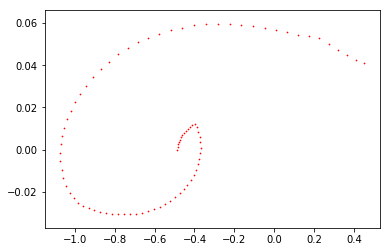

>>>>>Step 0 at [-0.48535774  0.        ]
NN verification via simulation
Utilize NN output [1.99879918]
[-0.48414572  0.00121202]
>>>>>Step 1 at [-0.48414572  0.00121202]
NN verification via simulation
Utilize NN output [1.99979328]
[-0.48172922  0.0024165 ]
>>>>>Step 2 at [-0.48172922  0.0024165 ]
NN verification via simulation
Utilize NN output [1.99975352]
[-0.47812628  0.00360294]
>>>>>Step 3 at [-0.47812628  0.00360294]
NN verification via simulation
Utilize NN output [1.99977174]
[-0.47336368  0.00476261]
>>>>>Step 4 at [-0.47336368  0.00476261]
NN verification via simulation
Utilize NN output [1.99988614]
[-0.46747658  0.0058871 ]
>>>>>Step 5 at [-0.46747658  0.0058871 ]
NN verification via simulation
Utilize NN output [1.99993831]
[-0.46050851  0.00696807]
>>>>>Step 6 at [-0.46050851  0.00696807]
NN verification via simulation
Utilize NN output [1.9999548]
[-0.45251086  0.00799765]
>>>>>Step 7 at [-0.45251086  0.00799765]
NN verification via simulation
Utilize NN output [1.99995

Utilize NN output [1.67611382]
[-0.63067335  0.05294259]
>>>>>Step 66 at [-0.63067335  0.05294259]
NN verification via simulation
Utilize NN output [1.78885787]
[-0.57575816  0.05491519]
>>>>>Step 67 at [-0.57575816  0.05491519]
NN verification via simulation
Utilize NN output [1.99144157]
[-0.5189662   0.05679196]
>>>>>Step 68 at [-0.5189662   0.05679196]
NN verification via simulation
Utilize NN output [1.71349607]
[-0.46113874  0.05782746]
>>>>>Step 69 at [-0.46113874  0.05782746]
NN verification via simulation
Utilize NN output [1.99632667]
[-0.40228251  0.05885623]
>>>>>Step 70 at [-0.40228251  0.05885623]
NN verification via simulation
Utilize NN output [1.99881308]
[-0.34281797  0.05946454]
>>>>>Step 71 at [-0.34281797  0.05946454]
NN verification via simulation
Utilize NN output [1.99861226]
[-0.28314588  0.05967209]
>>>>>Step 72 at [-0.28314588  0.05967209]
NN verification via simulation
Utilize NN output [1.99851985]
[-0.22362702  0.05951886]
>>>>>Step 73 at [-0.22362702  0.0

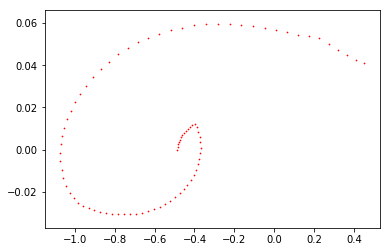

No intervention. Agent is clear.
[-0.48535774  0.        ]
Reached at step 87!!!!!
Episode 0	 reward: 0.00	 max_speed: 0.06


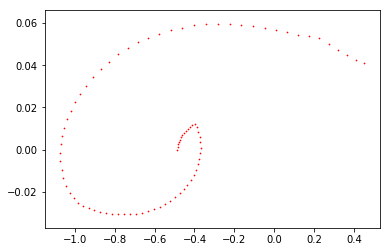

<<<<<<<<<<<<<<<<<<<<
Finished epoch 19






In [17]:
def QP(P_qp, q_qp, G_qp, h_qp, A_qp = None, b_qp = None):
    P_qp = numpy_sparse_to_spmatrix(P_qp)
    q_qp = matrix(q_qp)
    G_qp = numpy_sparse_to_spmatrix(G_qp)
    h_qp = matrix(h_qp)
    print("Starting solving QP")
    solvers.options['feastol'] = 1e-5
    sol=solvers.qp(P_qp, q_qp, G_qp, h_qp, A_qp, b_qp)
    #sol = {'x': [0.0 for i in range(dynamics.state_size * (N - n + 1) + agent_1.num_parameters(agent_1.model))]}
    theta_diffs = list(sol['x'])
    if theta_diffs is None:
        theta_diffs = np.zeros(agent_1.num_parameters(agent_1.model))
    return theta_diffs

# Define goal state where only the position matters 
def goal():
    return np.array([0.6, 0.07])

# Define upper bound barrier where both the position and velocity is the maximum
def barrier_u(x):
    if x[0] >= 0.45:
        return np.array([10.0, 0.04])
    else:
        return np.array([10.0, 10.09])
# Define lower bound barrier where both the position and velocity is the minimum    
def barrier_l(x):
    if x[0] <= -1.05:
        return np.array([-10.0, -0.04])
    else:
        return np.array([-10.0, -10.09])

# Define the nominal as being equal to the current state
def nominal(x):
    return goal()

A = np.array([[[0, 1.]], [[0, -1.]]])
b = np.array([[-0.0], [0.0]])
q1 = [00.0, 20.0]
q2 = [00.0, 20.0]


N = 200
x_nominal = 400 * [goal()] 

data_trajs = agent_trajs

num_epoch = 20
tol = 1e-5

for epoch in range(num_epoch):
    print(">>>>>>>>>>>>>>>>>>>>")
    print("Start epoch {}".format(epoch))
    # Initialize Q matrix 
    Q1 = []
    Qx = []
    Qu = []
    Qx_T = []
    Qu_T = []
    Qxx = []
    Quu = []
    Qux = []
    Qxu = []

    # Initialize K, k
    K = []
    k = []

    # Run the latest model and original model to get (pi_\theta - u^*)
    u_diffs = []
    # Run the latest model to get gradient on the input x   
    pix = []
    # Run the latest model to get gradient on \theta
    pitheta = []

    # Barrier 1st order and 2nd order
    b1 = []
    bx = []
    bx_T = []
    bxx = []

    xs_diff = []
    us_diff = []
        
    h_qp = []
    G_qp = []
    
    theta_diffs = np.zeros([len(data_trajs), agent_1.num_parameters(agent_1.model)])
    P_qp = np.eye(agent_1.num_parameters(agent_1.model))
    q_qp = np.zeros([agent_1.num_parameters(agent_1.model), 1])
    
    num_itr = 10
    
    for i_traj in range(len(data_trajs)):
        print("Optimize rajectory {}".format(i_traj))
        Q1.append(np.empty([len(data_trajs[i_traj]), 1, 1]))
        Qx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1])) 
        Qu.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))
        Qx_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.state_size])) 
        Qu_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.action_size]))
        Qxx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.state_size]))
        Quu.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.action_size]))
        Qux.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.state_size]))
        Qxu.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.action_size]))

        # Initialize K, k
        K.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.state_size]))
        k.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))

        # Run the latest model and original model to get (pi_\theta - u^*)
        u_diffs.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))
        # Run the latest model to get gradient on the input x   
        pix.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.action_size]))
        # Run the latest model to get gradient on \theta
        pitheta.append(np.empty([len(data_trajs[i_traj]), \
                                 agent_1.num_parameters(agent_1.model), dynamics.action_size]))

        # Barrier 1st order and 2nd order
        b1.append(np.empty([len(data_trajs[i_traj]), 1]))
        bx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1]))
        bx_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.state_size]))
        bxx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.state_size]))

        xs_diff.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1]))
        us_diff.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))

        h_qp.append(np.zeros([len(data_trajs[i_traj]) * dynamics.action_size, 1]))
        G_qp.append(np.zeros([len(data_trajs[i_traj]) * dynamics.action_size , \
                              agent_1.num_parameters(agent_1.model)]))
        
        data_traj_opt = data_trajs[i_traj][:]
        J_opt = float('inf')
        converged = False
        
        alphas = 0.9**(np.arange(num_itr)**2)
        mus = 1.1**(np.arange(num_itr)**2)
        
        for i_itr in range(num_itr**2):
            alpha = alphas[int(i_itr/num_itr)]
            mu = mus[int(i_itr%num_itr)] 
            
            data_traj = data_trajs[i_traj][:]
            x_new = np.reshape([i for i in data_traj[0][0][:dynamics.state_size]], [dynamics.state_size, 1])
            
            data_traj_tmp = []
            xs = []
            us = []
            
            agent_1.optimizer.zero_grad()
            J_new = 0.0
            
            for i_xy in range(len(data_traj)):
                x_y = data_traj[i_xy]
                x = np.reshape([i for i in x_y[0][:dynamics.state_size]], [dynamics.state_size, 1])
                u = np.reshape([i for i in x_y[1][:]], [dynamics.action_size, 1])
               
                x_u = x - np.reshape(barrier_u(x_y[0][:dynamics.state_size]), x.shape)
                x_l = x - np.reshape(barrier_l(x_y[0][:dynamics.state_size]), x.shape)

                b1[i_traj][i_xy] = q1[0] * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) - q1[0]\
                        + q1[1] * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) - q1[1]
                bx[i_traj][i_xy] = q1[0] * q2[0]\
                    * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) * A[0].T + q1[1] * q2[1]\
                    * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) * A[1].T
                
                bx_T[i_traj][i_xy] = bx[i_traj][i_xy].T

                bxx[i_traj][i_xy] = q1[0] * q2[0]**2\
                    * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) * A[0].T * A[0]\
                    + q1[1] * q2[1]**2\
                    * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) * A[1].T * A[1]

                i = abs(int(x[0]/0.5))
                x_nn = []
                for j in [x[:, 0]]:
                    for e in j:
                        x_nn.append(e)
                        
                x_nn = np.asarray(x_nn)
                x_input = torch.tensor([x_nn], requires_grad = True).to(agent_1.device)   
                u_output = agent_1.model(x_input)[0]
                
                for i in range(dynamics.action_size):
                    # Get gradient w.r.t input x[0:4] <<<< pix 
                    pix[i_traj][i_xy, :, i] = torch.autograd.grad(\
                    u_output[i], x_input, retain_graph = True)[0].cpu().numpy().T[0:dynamics.state_size, 0]

                    # Get gradient w.r.t model parameters theta <<<< g_theta
                    torch.autograd.backward(u_output[i], retain_graph = True)
                    j = 0
                    for theta in agent_1.model.parameters():
                        pitheta_ = theta.grad.data.flatten()
                        pitheta[i_traj][i_xy, j : j + pitheta_.size()[0], i] = pitheta_.cpu().numpy()
                        j += pitheta_.size()[0]    

                u_output = u_output.detach().cpu().numpy()
                u_output = np.reshape(u_output, [dynamics.action_size, 1])

                u_0 = agent_0.run(tensor([x_nn]).to(agent_0.device))[0]
                u_0 = np.reshape(u_0, [dynamics.action_size, 1])

                u_diffs[i_traj][i_xy] = u_output - u_0

                Q1[i_traj][i_xy] = 4 * b1[i_traj][i_xy]
                Qx[i_traj][i_xy] = -2 * pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy]) + \
                                    2 * bx[i_traj][i_xy]
                Qx_T[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T) + \
                                    2 * bx[i_traj][i_xy].T
                Qu[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy]
                Qu_T[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy].T

                Qxx[i_traj][i_xy] = (pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy])).dot(\
                                    u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T)) + 2 * bxx[i_traj][i_xy]
                Quu[i_traj][i_xy] = u_diffs[i_traj][i_xy].dot(u_diffs[i_traj][i_xy].T) + \
                            mu * np.eye(Quu[i_traj][i_xy].shape[0])
                Qux[i_traj][i_xy] = u_diffs[i_traj][i_xy].dot(u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T))
                Qxu[i_traj][i_xy] = (pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy])).dot(u_diffs[i_traj][i_xy].T)
                
                
                K[i_traj][i_xy] = - np.linalg.solve(Quu[i_traj][i_xy], Qux[i_traj][i_xy])
                k[i_traj][i_xy] = - np.linalg.solve(Quu[i_traj][i_xy], Qu[i_traj][i_xy])

                x_diff = x_new - x
                
                xs_diff[i_traj][i_xy] = x_diff

                us_diff[i_traj][i_xy] = alpha * k[i_traj][i_xy] + K[i_traj][i_xy].dot(x_diff)
                
                u_new = u_output + us_diff[i_traj][i_xy]
                u_new = u_new.flatten().tolist()
                x_new = x_new.flatten().tolist()

                data_traj_tmp.append([x_new, u_new])
                xs.append(x_new)
                us.append(u_new)

                if i_xy < len(data_traj) - 1:
                    x_new = dynamics.f(xs[-1], us[-1], i_xy)[0]
                    x_new = np.reshape(x_new, x.shape)

            if (np.squeeze((np.asarray(xs) - \
                np.asarray([barrier_u(x) for x in xs])).dot(A[0].T) - \
                           b[0,0] <= 0)).all() == True and \
               (np.squeeze((np.asarray(xs) - \
                np.asarray([barrier_l(x) for x in xs])).dot(A[1].T) - \
                           b[1,0] <= 0)).all() == True:
                if i_itr % 10 == 0:
                    print("Finished iteration {} [Safe]".format(i_itr))
                #draw_agent_traj([data_traj_tmp])
                
                # Calculate J_new
                
                '''
                # Option 1: Directly calculate the loss of the QP
                for i_xy in range(xs_diffs[i_traj].shape[0]):                    
                    J_new += np.sum(Q1[i_traj][i_xy] + \
                                    2 * xs_diff[i_traj][i_xy].T.dot(Qx[i_traj][i_xy]) + \
                                    2 * us_diff[i_traj][i_xy].T.dot(Qu[i_traj][i_xy]) + \
                                    2 * (xs_diff[i_traj][i_xy].T.dot(Qxu[i_traj][i_xy])).dot(us_diff[i_traj][i_xy]) + \
                                    (xs_diff[i_traj][i_xy].T.dot(Qxx[i_traj][i_xy])).dot(xs_diff[i_traj][i_xy]) + \
                                    (us_diff[i_traj][i_xy].T.dot(Quu[i_traj][i_xy])).dot(us_diff[i_traj][i_xy]))
                '''
                # Option 2: Calculate the loss of the original model on the new trajectory(s)
                #           The input to the original model should be rebuilt for every single state
                for i_xy in range(xs_diff[i_traj].shape[0]):
                    x = data_trajs[i_traj][i_xy][0]
                    u = data_trajs[i_traj][i_xy][1]
                    
                    x_ = np.asarray(x) + xs_diff[i_traj][i_xy].flatten()
                    i_ = abs(int(x[0]/0.5))
                    x_nn_ = []
                    for j_ in [x_]:
                        for k_ in j_:
                            x_nn_.append(k_)
                    
                    u_ = np.asarray(u) + us_diff[i_traj][i_xy].flatten()
                    u_0 = agent_0.run(tensor([x_nn_]).to(agent_0.device))[0]
                    J_new += np.linalg.norm(np.asarray(u_) - np.asarray(u_0), ord = 2 )
                    
                
                if J_opt > J_new:
                    if np.abs((J_opt - J_new)/J_opt) < tol:
                        converged = True
                        print("Converged.")
                        break
                    print("Found new optimal solution. Load QP parameters.")
                    for i_xy in range(len(data_traj)):
                        h_i = (us_diff[i_traj][i_xy].T - xs_diff[i_traj][i_xy].T.dot(pix[i_traj][i_xy])).T
                        G_i = pitheta[i_traj][i_xy].T

                        for j in range(dynamics.action_size):
                            h_qp[i_traj][i_xy + j, :] = h_i[j, 0]
                            G_qp[i_traj][i_xy + j, :] = G_i[j, :]
                    J_opt = J_new
                    data_traj_opt = data_traj_tmp[:]
                    
                #alpha = 1.1 * (1.0 + 0.9**i_itr) * alpha 
                #mu = 0.9 * (1.0 - 0.9**i_itr) * mu
                
            else:
                if i_itr % 10 == 0:
                    print("Finished iteration {} [Unsafe]".format(i_itr))  
                #draw_agent_traj([data_traj_tmp])
                #alpha = 0.9 * (1 - 0.9**i_itr) * alpha
                #mu = 1.1 * (1 + 0.9**i_itr) * mu 
        
        data_trajs[i_traj] = data_traj_opt[:]
        draw_trajs([data_traj_opt])
    
    
    pickle.dump((G_qp, h_qp), open('linear_eq.p', 'wb'))
    
    # Update the model
    '''   
    # Option 1
    # Solve the perturbations on the model parameters with minimal norm via QP
    # Each newly generated trajecotry corresponds to a perturbation
    # Use the average as the final result
    #for i_traj in range(len(theta_diffs)):  
    #    theta_diffs[i_traj] = np.asarray(QP(P_qp, q_qp, G_qp[i_traj], h_qp[i_traj]))
    #theta_diffs = np.mean(theta_diffs, axis = 0)
   
    # Option 2
    # Solve the perturbations on the model parameters with minimal norm via QP
    # All newly generated trajecotries are included in one constraint
    #h_qp = np.concatenate(h_qp[:])
    #G_qp = np.concatenate(G_qp[:])
    #theta_diffs = np.asarray(QP(P_qp, q_qp, G_qp, h_qp))

    
    # Option 3
    # Solve the perturbation on the model parameters via one linear equation
    h_qp = np.concatenate(h_qp[:])
    G_qp = np.concatenate(G_qp[:])
    theta_diffs = linalg.cgs(G_qp.T.dot(G_qp), G_qp.T.dot(h_qp))[0]
    theta_diffs = np.linalg.solve(G_qp.T.dot(G_qp) + np.eye(G_qp.shape[1]), G_qp.T.dot(h_qp))
     
    # Modify the model parameters by hand
    i = 0
    for theta in agent_1.model.parameters():
        theta.data += torch.Tensor(\
            np.reshape(theta_diffs[i: i + theta.data.numel()], theta.data.size())).double().to(agent_1.device)
        i += theta.data.numel()
    
   
    '''
    #train_trajs = [[i for i in traj] for traj in data_trajs]
    while True:
        num_interv = 0
        trajs, nn_trajs, mpc_trajs, data_trajs  = \
            train_pipeline(agent_1, x0s, data_trajs, paths = None, num_epoch = 1000)
        for i_traj in range(len(mpc_trajs)):
            num_interv += len(mpc_trajs[i_traj])
        if num_interv == 0:
            print("No intervention. Agent is clear.")
            break
        print("Intervention identified. Retrain agent in the pipeline.") 
     
        
    data_trajs = replay(agent_1, x0s)
    draw_trajs(data_trajs)
    print("<<<<<<<<<<<<<<<<<<<<")
    print("Finished epoch {}\n\n\n\n".format(epoch))
        